In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt

from utils import mnist
import numpy as np

In [2]:
def plot_train_test(logs, tpe='loss'):
    fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
    for index, log in enumerate(logs):
        keys = log.keys()
        logs = {k:[z for z in zip(*log[k])] for k in keys}
        epochs = {k:range(len(log[k])) for k in keys}

        if tpe == 'loss':
            handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label="train" if index==0 else "test") for k in keys])
            plt.title('errors')
            plt.xlabel('epoch')
            plt.ylabel('error')

        elif tpe == 'accuracy':
            handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
            plt.title('accuracy')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            
    plt.legend()
    plt.show()

In [3]:
train_loader, test_loader = mnist()

In [4]:
class Net(nn.Module):
    def __init__(self, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
#         self.fc5 = nn.Linear(64, 64)
#         self.fc6 = nn.Linear(64, 64)
#         self.fc7 = nn.Linear(64, 64)
#         self.fc8 = nn.Linear(64, 64)
        self.fc9 = nn.Linear(100, 10)
        self.optim = optim.Adam(self.parameters(), lr=lr)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
#         x = torch.sigmoid(self.fc5(x))
#         x = torch.sigmoid(self.fc6(x))
#         x = torch.sigmoid(self.fc7(x))
#         x = torch.sigmoid(self.fc8(x))
        x = self.fc9(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [5]:
def train(epoch, models, log=None):
#     train_size = len(train_loader.sampler)
    train_size = 1000
    train_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    limit = train_size / 100
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx == limit:
            break
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            train_loss[k] = loss.item()
            loss.backward()
            model.optim.step()
            pred = output.data.max(1, keepdim=True)[1]
            correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
        if batch_idx % 1 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)
    correct_pct = {k: 100. * correct[k] / train_size for k in correct}
    if log is not None:
        for k in models:
            log[k].append((train_loss[k], correct_pct[k]))

In [6]:
models = {'default': Net()}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [8]:
for epoch in range(1, 1001):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [0/1000 (0%)]	Losses default: 2.334298
Train Epoch: 1 [100/1000 (0%)]	Losses default: 2.331714
Train Epoch: 1 [200/1000 (0%)]	Losses default: 2.323779
Train Epoch: 1 [300/1000 (0%)]	Losses default: 2.327883
Train Epoch: 1 [400/1000 (0%)]	Losses default: 2.332189
Train Epoch: 1 [500/1000 (0%)]	Losses default: 2.326404
Train Epoch: 1 [600/1000 (1%)]	Losses default: 2.310628
Train Epoch: 1 [700/1000 (1%)]	Losses default: 2.324322
Train Epoch: 1 [800/1000 (1%)]	Losses default: 2.300990
Train Epoch: 1 [900/1000 (1%)]	Losses default: 2.319860
Test set:
default: Loss: 2.3157	Accuracy: 974.0/10000 (10%)

Train Epoch: 2 [0/1000 (0%)]	Losses default: 2.321632
Train Epoch: 2 [100/1000 (0%)]	Losses default: 2.321003
Train Epoch: 2 [200/1000 (0%)]	Losses default: 2.314602
Train Epoch: 2 [300/1000 (0%)]	Losses default: 2.317386
Train Epoch: 2 [400/1000 (0%)]	Losses default: 2.321493
Train Epoch: 2 [500/1000 (0%)]	Losses default: 2.317686
Train Epoch: 2 [600/1000 (1%)]	Losses default: 

Test set:
default: Loss: 2.2988	Accuracy: 1028.0/10000 (10%)

Train Epoch: 15 [0/1000 (0%)]	Losses default: 2.291149
Train Epoch: 15 [100/1000 (0%)]	Losses default: 2.291014
Train Epoch: 15 [200/1000 (0%)]	Losses default: 2.297530
Train Epoch: 15 [300/1000 (0%)]	Losses default: 2.283475
Train Epoch: 15 [400/1000 (0%)]	Losses default: 2.293996
Train Epoch: 15 [500/1000 (0%)]	Losses default: 2.299381
Train Epoch: 15 [600/1000 (1%)]	Losses default: 2.288809
Train Epoch: 15 [700/1000 (1%)]	Losses default: 2.311425
Train Epoch: 15 [800/1000 (1%)]	Losses default: 2.296054
Train Epoch: 15 [900/1000 (1%)]	Losses default: 2.283538
Test set:
default: Loss: 2.2983	Accuracy: 1028.0/10000 (10%)

Train Epoch: 16 [0/1000 (0%)]	Losses default: 2.290366
Train Epoch: 16 [100/1000 (0%)]	Losses default: 2.290307
Train Epoch: 16 [200/1000 (0%)]	Losses default: 2.296921
Train Epoch: 16 [300/1000 (0%)]	Losses default: 2.282695
Train Epoch: 16 [400/1000 (0%)]	Losses default: 2.293311
Train Epoch: 16 [500/1000

Test set:
default: Loss: 2.2791	Accuracy: 2051.0/10000 (21%)

Train Epoch: 29 [0/1000 (0%)]	Losses default: 2.267773
Train Epoch: 29 [100/1000 (0%)]	Losses default: 2.269959
Train Epoch: 29 [200/1000 (0%)]	Losses default: 2.274773
Train Epoch: 29 [300/1000 (0%)]	Losses default: 2.261187
Train Epoch: 29 [400/1000 (0%)]	Losses default: 2.271540
Train Epoch: 29 [500/1000 (0%)]	Losses default: 2.278071
Train Epoch: 29 [600/1000 (1%)]	Losses default: 2.265795
Train Epoch: 29 [700/1000 (1%)]	Losses default: 2.290123
Train Epoch: 29 [800/1000 (1%)]	Losses default: 2.273307
Train Epoch: 29 [900/1000 (1%)]	Losses default: 2.258426
Test set:
default: Loss: 2.2760	Accuracy: 2047.0/10000 (20%)

Train Epoch: 30 [0/1000 (0%)]	Losses default: 2.264107
Train Epoch: 30 [100/1000 (0%)]	Losses default: 2.266595
Train Epoch: 30 [200/1000 (0%)]	Losses default: 2.271062
Train Epoch: 30 [300/1000 (0%)]	Losses default: 2.257660
Train Epoch: 30 [400/1000 (0%)]	Losses default: 2.267941
Train Epoch: 30 [500/1000

Test set:
default: Loss: 2.1772	Accuracy: 4024.0/10000 (40%)

Train Epoch: 43 [0/1000 (0%)]	Losses default: 2.152097
Train Epoch: 43 [100/1000 (0%)]	Losses default: 2.159881
Train Epoch: 43 [200/1000 (0%)]	Losses default: 2.154843
Train Epoch: 43 [300/1000 (0%)]	Losses default: 2.146774
Train Epoch: 43 [400/1000 (0%)]	Losses default: 2.156244
Train Epoch: 43 [500/1000 (0%)]	Losses default: 2.165922
Train Epoch: 43 [600/1000 (1%)]	Losses default: 2.144791
Train Epoch: 43 [700/1000 (1%)]	Losses default: 2.177151
Train Epoch: 43 [800/1000 (1%)]	Losses default: 2.151424
Train Epoch: 43 [900/1000 (1%)]	Losses default: 2.124365
Test set:
default: Loss: 2.1642	Accuracy: 3980.0/10000 (40%)

Train Epoch: 44 [0/1000 (0%)]	Losses default: 2.137280
Train Epoch: 44 [100/1000 (0%)]	Losses default: 2.145594
Train Epoch: 44 [200/1000 (0%)]	Losses default: 2.139284
Train Epoch: 44 [300/1000 (0%)]	Losses default: 2.131951
Train Epoch: 44 [400/1000 (0%)]	Losses default: 2.141409
Train Epoch: 44 [500/1000

Test set:
default: Loss: 1.9653	Accuracy: 3952.0/10000 (40%)

Train Epoch: 57 [0/1000 (0%)]	Losses default: 1.907483
Train Epoch: 57 [100/1000 (0%)]	Losses default: 1.925342
Train Epoch: 57 [200/1000 (0%)]	Losses default: 1.895371
Train Epoch: 57 [300/1000 (0%)]	Losses default: 1.900945
Train Epoch: 57 [400/1000 (0%)]	Losses default: 1.910429
Train Epoch: 57 [500/1000 (0%)]	Losses default: 1.943872
Train Epoch: 57 [600/1000 (1%)]	Losses default: 1.897012
Train Epoch: 57 [700/1000 (1%)]	Losses default: 1.936172
Train Epoch: 57 [800/1000 (1%)]	Losses default: 1.906777
Train Epoch: 57 [900/1000 (1%)]	Losses default: 1.861217
Test set:
default: Loss: 1.9502	Accuracy: 3975.0/10000 (40%)

Train Epoch: 58 [0/1000 (0%)]	Losses default: 1.889561
Train Epoch: 58 [100/1000 (0%)]	Losses default: 1.908364
Train Epoch: 58 [200/1000 (0%)]	Losses default: 1.876557
Train Epoch: 58 [300/1000 (0%)]	Losses default: 1.883050
Train Epoch: 58 [400/1000 (0%)]	Losses default: 1.892428
Train Epoch: 58 [500/1000

Test set:
default: Loss: 1.7755	Accuracy: 4239.0/10000 (42%)

Train Epoch: 71 [0/1000 (0%)]	Losses default: 1.672365
Train Epoch: 71 [100/1000 (0%)]	Losses default: 1.707097
Train Epoch: 71 [200/1000 (0%)]	Losses default: 1.657892
Train Epoch: 71 [300/1000 (0%)]	Losses default: 1.674055
Train Epoch: 71 [400/1000 (0%)]	Losses default: 1.680058
Train Epoch: 71 [500/1000 (0%)]	Losses default: 1.749700
Train Epoch: 71 [600/1000 (1%)]	Losses default: 1.666115
Train Epoch: 71 [700/1000 (1%)]	Losses default: 1.702831
Train Epoch: 71 [800/1000 (1%)]	Losses default: 1.690150
Train Epoch: 71 [900/1000 (1%)]	Losses default: 1.633727
Test set:
default: Loss: 1.7638	Accuracy: 4261.0/10000 (43%)

Train Epoch: 72 [0/1000 (0%)]	Losses default: 1.657352
Train Epoch: 72 [100/1000 (0%)]	Losses default: 1.693279
Train Epoch: 72 [200/1000 (0%)]	Losses default: 1.643131
Train Epoch: 72 [300/1000 (0%)]	Losses default: 1.659870
Train Epoch: 72 [400/1000 (0%)]	Losses default: 1.665557
Train Epoch: 72 [500/1000

Test set:
default: Loss: 1.6369	Accuracy: 4660.0/10000 (47%)

Train Epoch: 85 [0/1000 (0%)]	Losses default: 1.491621
Train Epoch: 85 [100/1000 (0%)]	Losses default: 1.535606
Train Epoch: 85 [200/1000 (0%)]	Losses default: 1.477175
Train Epoch: 85 [300/1000 (0%)]	Losses default: 1.497466
Train Epoch: 85 [400/1000 (0%)]	Losses default: 1.501615
Train Epoch: 85 [500/1000 (0%)]	Losses default: 1.597033
Train Epoch: 85 [600/1000 (1%)]	Losses default: 1.491700
Train Epoch: 85 [700/1000 (1%)]	Losses default: 1.524886
Train Epoch: 85 [800/1000 (1%)]	Losses default: 1.526392
Train Epoch: 85 [900/1000 (1%)]	Losses default: 1.463881
Test set:
default: Loss: 1.6289	Accuracy: 4699.0/10000 (47%)

Train Epoch: 86 [0/1000 (0%)]	Losses default: 1.480991
Train Epoch: 86 [100/1000 (0%)]	Losses default: 1.525062
Train Epoch: 86 [200/1000 (0%)]	Losses default: 1.466180
Train Epoch: 86 [300/1000 (0%)]	Losses default: 1.486459
Train Epoch: 86 [400/1000 (0%)]	Losses default: 1.490706
Train Epoch: 86 [500/1000

Test set:
default: Loss: 1.5406	Accuracy: 5106.0/10000 (51%)

Train Epoch: 99 [0/1000 (0%)]	Losses default: 1.361599
Train Epoch: 99 [100/1000 (0%)]	Losses default: 1.404130
Train Epoch: 99 [200/1000 (0%)]	Losses default: 1.338260
Train Epoch: 99 [300/1000 (0%)]	Losses default: 1.356530
Train Epoch: 99 [400/1000 (0%)]	Losses default: 1.365334
Train Epoch: 99 [500/1000 (0%)]	Losses default: 1.474957
Train Epoch: 99 [600/1000 (1%)]	Losses default: 1.363501
Train Epoch: 99 [700/1000 (1%)]	Losses default: 1.395493
Train Epoch: 99 [800/1000 (1%)]	Losses default: 1.406612
Train Epoch: 99 [900/1000 (1%)]	Losses default: 1.332781
Test set:
default: Loss: 1.5347	Accuracy: 5136.0/10000 (51%)

Train Epoch: 100 [0/1000 (0%)]	Losses default: 1.353472
Train Epoch: 100 [100/1000 (0%)]	Losses default: 1.395787
Train Epoch: 100 [200/1000 (0%)]	Losses default: 1.329275
Train Epoch: 100 [300/1000 (0%)]	Losses default: 1.347253
Train Epoch: 100 [400/1000 (0%)]	Losses default: 1.356778
Train Epoch: 100 [50

Test set:
default: Loss: 1.4688	Accuracy: 5365.0/10000 (54%)

Train Epoch: 112 [0/1000 (0%)]	Losses default: 1.261813
Train Epoch: 112 [100/1000 (0%)]	Losses default: 1.301626
Train Epoch: 112 [200/1000 (0%)]	Losses default: 1.226553
Train Epoch: 112 [300/1000 (0%)]	Losses default: 1.239239
Train Epoch: 112 [400/1000 (0%)]	Losses default: 1.261044
Train Epoch: 112 [500/1000 (0%)]	Losses default: 1.374222
Train Epoch: 112 [600/1000 (1%)]	Losses default: 1.258213
Train Epoch: 112 [700/1000 (1%)]	Losses default: 1.292688
Train Epoch: 112 [800/1000 (1%)]	Losses default: 1.315071
Train Epoch: 112 [900/1000 (1%)]	Losses default: 1.227488
Test set:
default: Loss: 1.4636	Accuracy: 5371.0/10000 (54%)

Train Epoch: 113 [0/1000 (0%)]	Losses default: 1.254433
Train Epoch: 113 [100/1000 (0%)]	Losses default: 1.294171
Train Epoch: 113 [200/1000 (0%)]	Losses default: 1.218311
Train Epoch: 113 [300/1000 (0%)]	Losses default: 1.230356
Train Epoch: 113 [400/1000 (0%)]	Losses default: 1.253454
Train Epoc

Test set:
default: Loss: 1.4029	Accuracy: 5379.0/10000 (54%)

Train Epoch: 125 [0/1000 (0%)]	Losses default: 1.165148
Train Epoch: 125 [100/1000 (0%)]	Losses default: 1.208027
Train Epoch: 125 [200/1000 (0%)]	Losses default: 1.122650
Train Epoch: 125 [300/1000 (0%)]	Losses default: 1.124125
Train Epoch: 125 [400/1000 (0%)]	Losses default: 1.165351
Train Epoch: 125 [500/1000 (0%)]	Losses default: 1.281204
Train Epoch: 125 [600/1000 (1%)]	Losses default: 1.151224
Train Epoch: 125 [700/1000 (1%)]	Losses default: 1.191624
Train Epoch: 125 [800/1000 (1%)]	Losses default: 1.227923
Train Epoch: 125 [900/1000 (1%)]	Losses default: 1.128318
Test set:
default: Loss: 1.3980	Accuracy: 5371.0/10000 (54%)

Train Epoch: 126 [0/1000 (0%)]	Losses default: 1.157687
Train Epoch: 126 [100/1000 (0%)]	Losses default: 1.201070
Train Epoch: 126 [200/1000 (0%)]	Losses default: 1.114994
Train Epoch: 126 [300/1000 (0%)]	Losses default: 1.115423
Train Epoch: 126 [400/1000 (0%)]	Losses default: 1.158237
Train Epoc

Test set:
default: Loss: 1.3419	Accuracy: 5502.0/10000 (55%)

Train Epoch: 138 [0/1000 (0%)]	Losses default: 1.070525
Train Epoch: 138 [100/1000 (0%)]	Losses default: 1.119629
Train Epoch: 138 [200/1000 (0%)]	Losses default: 1.028368
Train Epoch: 138 [300/1000 (0%)]	Losses default: 1.016742
Train Epoch: 138 [400/1000 (0%)]	Losses default: 1.076141
Train Epoch: 138 [500/1000 (0%)]	Losses default: 1.194025
Train Epoch: 138 [600/1000 (1%)]	Losses default: 1.044636
Train Epoch: 138 [700/1000 (1%)]	Losses default: 1.093556
Train Epoch: 138 [800/1000 (1%)]	Losses default: 1.141627
Train Epoch: 138 [900/1000 (1%)]	Losses default: 1.032326
Test set:
default: Loss: 1.3375	Accuracy: 5518.0/10000 (55%)

Train Epoch: 139 [0/1000 (0%)]	Losses default: 1.063396
Train Epoch: 139 [100/1000 (0%)]	Losses default: 1.113006
Train Epoch: 139 [200/1000 (0%)]	Losses default: 1.021654
Train Epoch: 139 [300/1000 (0%)]	Losses default: 1.009125
Train Epoch: 139 [400/1000 (0%)]	Losses default: 1.069620
Train Epoc

Test set:
default: Loss: 1.2883	Accuracy: 5804.0/10000 (58%)

Train Epoch: 151 [0/1000 (0%)]	Losses default: 0.973245
Train Epoch: 151 [100/1000 (0%)]	Losses default: 1.034647
Train Epoch: 151 [200/1000 (0%)]	Losses default: 0.947360
Train Epoch: 151 [300/1000 (0%)]	Losses default: 0.925742
Train Epoch: 151 [400/1000 (0%)]	Losses default: 0.995502
Train Epoch: 151 [500/1000 (0%)]	Losses default: 1.108510
Train Epoch: 151 [600/1000 (1%)]	Losses default: 0.956823
Train Epoch: 151 [700/1000 (1%)]	Losses default: 1.005477
Train Epoch: 151 [800/1000 (1%)]	Losses default: 1.059580
Train Epoch: 151 [900/1000 (1%)]	Losses default: 0.945455
Test set:
default: Loss: 1.2845	Accuracy: 5831.0/10000 (58%)

Train Epoch: 152 [0/1000 (0%)]	Losses default: 0.964987
Train Epoch: 152 [100/1000 (0%)]	Losses default: 1.028039
Train Epoch: 152 [200/1000 (0%)]	Losses default: 0.941633
Train Epoch: 152 [300/1000 (0%)]	Losses default: 0.919436
Train Epoch: 152 [400/1000 (0%)]	Losses default: 0.989665
Train Epoc

Test set:
default: Loss: 1.2451	Accuracy: 6121.0/10000 (61%)

Train Epoch: 164 [0/1000 (0%)]	Losses default: 0.879226
Train Epoch: 164 [100/1000 (0%)]	Losses default: 0.946741
Train Epoch: 164 [200/1000 (0%)]	Losses default: 0.876067
Train Epoch: 164 [300/1000 (0%)]	Losses default: 0.849526
Train Epoch: 164 [400/1000 (0%)]	Losses default: 0.923419
Train Epoch: 164 [500/1000 (0%)]	Losses default: 1.019487
Train Epoch: 164 [600/1000 (1%)]	Losses default: 0.881595
Train Epoch: 164 [700/1000 (1%)]	Losses default: 0.929014
Train Epoch: 164 [800/1000 (1%)]	Losses default: 0.976204
Train Epoch: 164 [900/1000 (1%)]	Losses default: 0.872370
Test set:
default: Loss: 1.2422	Accuracy: 6140.0/10000 (61%)

Train Epoch: 165 [0/1000 (0%)]	Losses default: 0.873112
Train Epoch: 165 [100/1000 (0%)]	Losses default: 0.940505
Train Epoch: 165 [200/1000 (0%)]	Losses default: 0.870888
Train Epoch: 165 [300/1000 (0%)]	Losses default: 0.844105
Train Epoch: 165 [400/1000 (0%)]	Losses default: 0.918151
Train Epoc

Test set:
default: Loss: 1.2096	Accuracy: 6362.0/10000 (64%)

Train Epoch: 177 [0/1000 (0%)]	Losses default: 0.804467
Train Epoch: 177 [100/1000 (0%)]	Losses default: 0.874305
Train Epoch: 177 [200/1000 (0%)]	Losses default: 0.811329
Train Epoch: 177 [300/1000 (0%)]	Losses default: 0.783010
Train Epoch: 177 [400/1000 (0%)]	Losses default: 0.858063
Train Epoch: 177 [500/1000 (0%)]	Losses default: 0.934672
Train Epoch: 177 [600/1000 (1%)]	Losses default: 0.813236
Train Epoch: 177 [700/1000 (1%)]	Losses default: 0.854295
Train Epoch: 177 [800/1000 (1%)]	Losses default: 0.889077
Train Epoch: 177 [900/1000 (1%)]	Losses default: 0.809599
Test set:
default: Loss: 1.2071	Accuracy: 6392.0/10000 (64%)

Train Epoch: 178 [0/1000 (0%)]	Losses default: 0.798966
Train Epoch: 178 [100/1000 (0%)]	Losses default: 0.869251
Train Epoch: 178 [200/1000 (0%)]	Losses default: 0.806445
Train Epoch: 178 [300/1000 (0%)]	Losses default: 0.778157
Train Epoch: 178 [400/1000 (0%)]	Losses default: 0.853353
Train Epoc

Test set:
default: Loss: 1.1780	Accuracy: 6577.0/10000 (66%)

Train Epoch: 190 [0/1000 (0%)]	Losses default: 0.735550
Train Epoch: 190 [100/1000 (0%)]	Losses default: 0.810983
Train Epoch: 190 [200/1000 (0%)]	Losses default: 0.746775
Train Epoch: 190 [300/1000 (0%)]	Losses default: 0.722066
Train Epoch: 190 [400/1000 (0%)]	Losses default: 0.799750
Train Epoch: 190 [500/1000 (0%)]	Losses default: 0.861741
Train Epoch: 190 [600/1000 (1%)]	Losses default: 0.751581
Train Epoch: 190 [700/1000 (1%)]	Losses default: 0.783610
Train Epoch: 190 [800/1000 (1%)]	Losses default: 0.809152
Train Epoch: 190 [900/1000 (1%)]	Losses default: 0.751882
Test set:
default: Loss: 1.1757	Accuracy: 6595.0/10000 (66%)

Train Epoch: 191 [0/1000 (0%)]	Losses default: 0.730474
Train Epoch: 191 [100/1000 (0%)]	Losses default: 0.806222
Train Epoch: 191 [200/1000 (0%)]	Losses default: 0.741521
Train Epoch: 191 [300/1000 (0%)]	Losses default: 0.717549
Train Epoch: 191 [400/1000 (0%)]	Losses default: 0.795467
Train Epoc

Test set:
default: Loss: 1.1492	Accuracy: 6806.0/10000 (68%)

Train Epoch: 203 [0/1000 (0%)]	Losses default: 0.671514
Train Epoch: 203 [100/1000 (0%)]	Losses default: 0.748455
Train Epoch: 203 [200/1000 (0%)]	Losses default: 0.674724
Train Epoch: 203 [300/1000 (0%)]	Losses default: 0.664758
Train Epoch: 203 [400/1000 (0%)]	Losses default: 0.745444
Train Epoch: 203 [500/1000 (0%)]	Losses default: 0.785563
Train Epoch: 203 [600/1000 (1%)]	Losses default: 0.695336
Train Epoch: 203 [700/1000 (1%)]	Losses default: 0.715724
Train Epoch: 203 [800/1000 (1%)]	Losses default: 0.734678
Train Epoch: 203 [900/1000 (1%)]	Losses default: 0.697511
Test set:
default: Loss: 1.1471	Accuracy: 6810.0/10000 (68%)

Train Epoch: 204 [0/1000 (0%)]	Losses default: 0.666808
Train Epoch: 204 [100/1000 (0%)]	Losses default: 0.743493
Train Epoch: 204 [200/1000 (0%)]	Losses default: 0.669568
Train Epoch: 204 [300/1000 (0%)]	Losses default: 0.660442
Train Epoch: 204 [400/1000 (0%)]	Losses default: 0.741329
Train Epoc

Test set:
default: Loss: 1.1240	Accuracy: 6945.0/10000 (69%)

Train Epoch: 216 [0/1000 (0%)]	Losses default: 0.613344
Train Epoch: 216 [100/1000 (0%)]	Losses default: 0.675698
Train Epoch: 216 [200/1000 (0%)]	Losses default: 0.612488
Train Epoch: 216 [300/1000 (0%)]	Losses default: 0.609709
Train Epoch: 216 [400/1000 (0%)]	Losses default: 0.692582
Train Epoch: 216 [500/1000 (0%)]	Losses default: 0.697821
Train Epoch: 216 [600/1000 (1%)]	Losses default: 0.641379
Train Epoch: 216 [700/1000 (1%)]	Losses default: 0.648386
Train Epoch: 216 [800/1000 (1%)]	Losses default: 0.665622
Train Epoch: 216 [900/1000 (1%)]	Losses default: 0.646286
Test set:
default: Loss: 1.1223	Accuracy: 6953.0/10000 (70%)

Train Epoch: 217 [0/1000 (0%)]	Losses default: 0.609045
Train Epoch: 217 [100/1000 (0%)]	Losses default: 0.669303
Train Epoch: 217 [200/1000 (0%)]	Losses default: 0.607975
Train Epoch: 217 [300/1000 (0%)]	Losses default: 0.605584
Train Epoch: 217 [400/1000 (0%)]	Losses default: 0.688569
Train Epoc

Test set:
default: Loss: 1.1041	Accuracy: 7019.0/10000 (70%)

Train Epoch: 229 [0/1000 (0%)]	Losses default: 0.554981
Train Epoch: 229 [100/1000 (0%)]	Losses default: 0.602477
Train Epoch: 229 [200/1000 (0%)]	Losses default: 0.554920
Train Epoch: 229 [300/1000 (0%)]	Losses default: 0.555741
Train Epoch: 229 [400/1000 (0%)]	Losses default: 0.639981
Train Epoch: 229 [500/1000 (0%)]	Losses default: 0.610190
Train Epoch: 229 [600/1000 (1%)]	Losses default: 0.588163
Train Epoch: 229 [700/1000 (1%)]	Losses default: 0.580358
Train Epoch: 229 [800/1000 (1%)]	Losses default: 0.601315
Train Epoch: 229 [900/1000 (1%)]	Losses default: 0.597390
Test set:
default: Loss: 1.1027	Accuracy: 7021.0/10000 (70%)

Train Epoch: 230 [0/1000 (0%)]	Losses default: 0.550507
Train Epoch: 230 [100/1000 (0%)]	Losses default: 0.597582
Train Epoch: 230 [200/1000 (0%)]	Losses default: 0.550549
Train Epoch: 230 [300/1000 (0%)]	Losses default: 0.551573
Train Epoch: 230 [400/1000 (0%)]	Losses default: 0.635943
Train Epoc

Train Epoch: 241 [900/1000 (1%)]	Losses default: 0.553677
Test set:
default: Loss: 1.0869	Accuracy: 7078.0/10000 (71%)

Train Epoch: 242 [0/1000 (0%)]	Losses default: 0.498894
Train Epoch: 242 [100/1000 (0%)]	Losses default: 0.541948
Train Epoch: 242 [200/1000 (0%)]	Losses default: 0.499959
Train Epoch: 242 [300/1000 (0%)]	Losses default: 0.502509
Train Epoch: 242 [400/1000 (0%)]	Losses default: 0.588239
Train Epoch: 242 [500/1000 (0%)]	Losses default: 0.543500
Train Epoch: 242 [600/1000 (1%)]	Losses default: 0.536915
Train Epoch: 242 [700/1000 (1%)]	Losses default: 0.520611
Train Epoch: 242 [800/1000 (1%)]	Losses default: 0.538791
Train Epoch: 242 [900/1000 (1%)]	Losses default: 0.550095
Test set:
default: Loss: 1.0856	Accuracy: 7076.0/10000 (71%)

Train Epoch: 243 [0/1000 (0%)]	Losses default: 0.494773
Train Epoch: 243 [100/1000 (0%)]	Losses default: 0.537467
Train Epoch: 243 [200/1000 (0%)]	Losses default: 0.495934
Train Epoch: 243 [300/1000 (0%)]	Losses default: 0.498510
Train Epoc

Test set:
default: Loss: 1.0715	Accuracy: 7124.0/10000 (71%)

Train Epoch: 255 [0/1000 (0%)]	Losses default: 0.447752
Train Epoch: 255 [100/1000 (0%)]	Losses default: 0.484412
Train Epoch: 255 [200/1000 (0%)]	Losses default: 0.449962
Train Epoch: 255 [300/1000 (0%)]	Losses default: 0.451686
Train Epoch: 255 [400/1000 (0%)]	Losses default: 0.538111
Train Epoch: 255 [500/1000 (0%)]	Losses default: 0.484973
Train Epoch: 255 [600/1000 (1%)]	Losses default: 0.489312
Train Epoch: 255 [700/1000 (1%)]	Losses default: 0.468206
Train Epoch: 255 [800/1000 (1%)]	Losses default: 0.478711
Train Epoch: 255 [900/1000 (1%)]	Losses default: 0.504220
Test set:
default: Loss: 1.0704	Accuracy: 7125.0/10000 (71%)

Train Epoch: 256 [0/1000 (0%)]	Losses default: 0.444038
Train Epoch: 256 [100/1000 (0%)]	Losses default: 0.480047
Train Epoch: 256 [200/1000 (0%)]	Losses default: 0.446309
Train Epoch: 256 [300/1000 (0%)]	Losses default: 0.447886
Train Epoch: 256 [400/1000 (0%)]	Losses default: 0.534287
Train Epoc

Test set:
default: Loss: 1.0577	Accuracy: 7162.0/10000 (72%)

Train Epoch: 268 [0/1000 (0%)]	Losses default: 0.401509
Train Epoch: 268 [100/1000 (0%)]	Losses default: 0.429191
Train Epoch: 268 [200/1000 (0%)]	Losses default: 0.403997
Train Epoch: 268 [300/1000 (0%)]	Losses default: 0.403603
Train Epoch: 268 [400/1000 (0%)]	Losses default: 0.486988
Train Epoch: 268 [500/1000 (0%)]	Losses default: 0.431582
Train Epoch: 268 [600/1000 (1%)]	Losses default: 0.445168
Train Epoch: 268 [700/1000 (1%)]	Losses default: 0.419245
Train Epoch: 268 [800/1000 (1%)]	Losses default: 0.422706
Train Epoch: 268 [900/1000 (1%)]	Losses default: 0.459353
Test set:
default: Loss: 1.0566	Accuracy: 7168.0/10000 (72%)

Train Epoch: 269 [0/1000 (0%)]	Losses default: 0.398083
Train Epoch: 269 [100/1000 (0%)]	Losses default: 0.425132
Train Epoch: 269 [200/1000 (0%)]	Losses default: 0.400537
Train Epoch: 269 [300/1000 (0%)]	Losses default: 0.400022
Train Epoch: 269 [400/1000 (0%)]	Losses default: 0.482721
Train Epoc

Test set:
default: Loss: 1.0428	Accuracy: 7252.0/10000 (73%)

Train Epoch: 281 [0/1000 (0%)]	Losses default: 0.358308
Train Epoch: 281 [100/1000 (0%)]	Losses default: 0.378157
Train Epoch: 281 [200/1000 (0%)]	Losses default: 0.357754
Train Epoch: 281 [300/1000 (0%)]	Losses default: 0.357641
Train Epoch: 281 [400/1000 (0%)]	Losses default: 0.414512
Train Epoch: 281 [500/1000 (0%)]	Losses default: 0.381994
Train Epoch: 281 [600/1000 (1%)]	Losses default: 0.404173
Train Epoch: 281 [700/1000 (1%)]	Losses default: 0.369345
Train Epoch: 281 [800/1000 (1%)]	Losses default: 0.369808
Train Epoch: 281 [900/1000 (1%)]	Losses default: 0.415008
Test set:
default: Loss: 1.0414	Accuracy: 7259.0/10000 (73%)

Train Epoch: 282 [0/1000 (0%)]	Losses default: 0.355080
Train Epoch: 282 [100/1000 (0%)]	Losses default: 0.374302
Train Epoch: 282 [200/1000 (0%)]	Losses default: 0.353952
Train Epoch: 282 [300/1000 (0%)]	Losses default: 0.354088
Train Epoch: 282 [400/1000 (0%)]	Losses default: 0.408210
Train Epoc

Test set:
default: Loss: 1.0239	Accuracy: 7340.0/10000 (73%)

Train Epoch: 294 [0/1000 (0%)]	Losses default: 0.315335
Train Epoch: 294 [100/1000 (0%)]	Losses default: 0.325976
Train Epoch: 294 [200/1000 (0%)]	Losses default: 0.304197
Train Epoch: 294 [300/1000 (0%)]	Losses default: 0.307120
Train Epoch: 294 [400/1000 (0%)]	Losses default: 0.351159
Train Epoch: 294 [500/1000 (0%)]	Losses default: 0.335196
Train Epoch: 294 [600/1000 (1%)]	Losses default: 0.365292
Train Epoch: 294 [700/1000 (1%)]	Losses default: 0.314580
Train Epoch: 294 [800/1000 (1%)]	Losses default: 0.316077
Train Epoch: 294 [900/1000 (1%)]	Losses default: 0.372705
Test set:
default: Loss: 1.0224	Accuracy: 7345.0/10000 (73%)

Train Epoch: 295 [0/1000 (0%)]	Losses default: 0.312030
Train Epoch: 295 [100/1000 (0%)]	Losses default: 0.321787
Train Epoch: 295 [200/1000 (0%)]	Losses default: 0.300261
Train Epoch: 295 [300/1000 (0%)]	Losses default: 0.302845
Train Epoch: 295 [400/1000 (0%)]	Losses default: 0.346705
Train Epoc

Test set:
default: Loss: 1.0069	Accuracy: 7423.0/10000 (74%)

Train Epoch: 307 [0/1000 (0%)]	Losses default: 0.272105
Train Epoch: 307 [100/1000 (0%)]	Losses default: 0.272769
Train Epoch: 307 [200/1000 (0%)]	Losses default: 0.260133
Train Epoch: 307 [300/1000 (0%)]	Losses default: 0.256059
Train Epoch: 307 [400/1000 (0%)]	Losses default: 0.298731
Train Epoch: 307 [500/1000 (0%)]	Losses default: 0.292728
Train Epoch: 307 [600/1000 (1%)]	Losses default: 0.327203
Train Epoch: 307 [700/1000 (1%)]	Losses default: 0.263783
Train Epoch: 307 [800/1000 (1%)]	Losses default: 0.265511
Train Epoch: 307 [900/1000 (1%)]	Losses default: 0.333121
Test set:
default: Loss: 1.0057	Accuracy: 7425.0/10000 (74%)

Train Epoch: 308 [0/1000 (0%)]	Losses default: 0.268604
Train Epoch: 308 [100/1000 (0%)]	Losses default: 0.268956
Train Epoch: 308 [200/1000 (0%)]	Losses default: 0.257110
Train Epoch: 308 [300/1000 (0%)]	Losses default: 0.252596
Train Epoch: 308 [400/1000 (0%)]	Losses default: 0.295152
Train Epoc

Test set:
default: Loss: 0.9935	Accuracy: 7487.0/10000 (75%)

Train Epoch: 320 [0/1000 (0%)]	Losses default: 0.225332
Train Epoch: 320 [100/1000 (0%)]	Losses default: 0.228348
Train Epoch: 320 [200/1000 (0%)]	Losses default: 0.220823
Train Epoch: 320 [300/1000 (0%)]	Losses default: 0.214752
Train Epoch: 320 [400/1000 (0%)]	Losses default: 0.255475
Train Epoch: 320 [500/1000 (0%)]	Losses default: 0.254569
Train Epoch: 320 [600/1000 (1%)]	Losses default: 0.291373
Train Epoch: 320 [700/1000 (1%)]	Losses default: 0.221127
Train Epoch: 320 [800/1000 (1%)]	Losses default: 0.222800
Train Epoch: 320 [900/1000 (1%)]	Losses default: 0.299416
Test set:
default: Loss: 0.9927	Accuracy: 7491.0/10000 (75%)

Train Epoch: 321 [0/1000 (0%)]	Losses default: 0.222038
Train Epoch: 321 [100/1000 (0%)]	Losses default: 0.225434
Train Epoch: 321 [200/1000 (0%)]	Losses default: 0.217761
Train Epoch: 321 [300/1000 (0%)]	Losses default: 0.211881
Train Epoch: 321 [400/1000 (0%)]	Losses default: 0.252362
Train Epoc

Train Epoch: 332 [900/1000 (1%)]	Losses default: 0.273851
Test set:
default: Loss: 0.9841	Accuracy: 7522.0/10000 (75%)

Train Epoch: 333 [0/1000 (0%)]	Losses default: 0.185749
Train Epoch: 333 [100/1000 (0%)]	Losses default: 0.195233
Train Epoch: 333 [200/1000 (0%)]	Losses default: 0.182535
Train Epoch: 333 [300/1000 (0%)]	Losses default: 0.180652
Train Epoch: 333 [400/1000 (0%)]	Losses default: 0.218629
Train Epoch: 333 [500/1000 (0%)]	Losses default: 0.216524
Train Epoch: 333 [600/1000 (1%)]	Losses default: 0.255494
Train Epoch: 333 [700/1000 (1%)]	Losses default: 0.185792
Train Epoch: 333 [800/1000 (1%)]	Losses default: 0.188971
Train Epoch: 333 [900/1000 (1%)]	Losses default: 0.271931
Test set:
default: Loss: 0.9836	Accuracy: 7523.0/10000 (75%)

Train Epoch: 334 [0/1000 (0%)]	Losses default: 0.182947
Train Epoch: 334 [100/1000 (0%)]	Losses default: 0.193022
Train Epoch: 334 [200/1000 (0%)]	Losses default: 0.179911
Train Epoch: 334 [300/1000 (0%)]	Losses default: 0.178311
Train Epoc

Test set:
default: Loss: 0.9820	Accuracy: 7541.0/10000 (75%)

Train Epoch: 346 [0/1000 (0%)]	Losses default: 0.154372
Train Epoch: 346 [100/1000 (0%)]	Losses default: 0.168711
Train Epoch: 346 [200/1000 (0%)]	Losses default: 0.153062
Train Epoch: 346 [300/1000 (0%)]	Losses default: 0.153392
Train Epoch: 346 [400/1000 (0%)]	Losses default: 0.190391
Train Epoch: 346 [500/1000 (0%)]	Losses default: 0.184198
Train Epoch: 346 [600/1000 (1%)]	Losses default: 0.217021
Train Epoch: 346 [700/1000 (1%)]	Losses default: 0.156831
Train Epoch: 346 [800/1000 (1%)]	Losses default: 0.161399
Train Epoch: 346 [900/1000 (1%)]	Losses default: 0.249428
Test set:
default: Loss: 0.9822	Accuracy: 7546.0/10000 (75%)

Train Epoch: 347 [0/1000 (0%)]	Losses default: 0.152372
Train Epoch: 347 [100/1000 (0%)]	Losses default: 0.166847
Train Epoch: 347 [200/1000 (0%)]	Losses default: 0.151154
Train Epoch: 347 [300/1000 (0%)]	Losses default: 0.151573
Train Epoch: 347 [400/1000 (0%)]	Losses default: 0.188499
Train Epoc

Test set:
default: Loss: 0.9867	Accuracy: 7557.0/10000 (76%)

Train Epoch: 359 [0/1000 (0%)]	Losses default: 0.131399
Train Epoch: 359 [100/1000 (0%)]	Losses default: 0.145719
Train Epoch: 359 [200/1000 (0%)]	Losses default: 0.131151
Train Epoch: 359 [300/1000 (0%)]	Losses default: 0.132280
Train Epoch: 359 [400/1000 (0%)]	Losses default: 0.168349
Train Epoch: 359 [500/1000 (0%)]	Losses default: 0.162293
Train Epoch: 359 [600/1000 (1%)]	Losses default: 0.177644
Train Epoch: 359 [700/1000 (1%)]	Losses default: 0.134590
Train Epoch: 359 [800/1000 (1%)]	Losses default: 0.138455
Train Epoch: 359 [900/1000 (1%)]	Losses default: 0.231288
Test set:
default: Loss: 0.9871	Accuracy: 7561.0/10000 (76%)

Train Epoch: 360 [0/1000 (0%)]	Losses default: 0.129832
Train Epoch: 360 [100/1000 (0%)]	Losses default: 0.144028
Train Epoch: 360 [200/1000 (0%)]	Losses default: 0.129672
Train Epoch: 360 [300/1000 (0%)]	Losses default: 0.130841
Train Epoch: 360 [400/1000 (0%)]	Losses default: 0.166841
Train Epoc

Test set:
default: Loss: 0.9937	Accuracy: 7567.0/10000 (76%)

Train Epoch: 372 [0/1000 (0%)]	Losses default: 0.112997
Train Epoch: 372 [100/1000 (0%)]	Losses default: 0.124706
Train Epoch: 372 [200/1000 (0%)]	Losses default: 0.113636
Train Epoch: 372 [300/1000 (0%)]	Losses default: 0.115215
Train Epoch: 372 [400/1000 (0%)]	Losses default: 0.150393
Train Epoch: 372 [500/1000 (0%)]	Losses default: 0.145011
Train Epoch: 372 [600/1000 (1%)]	Losses default: 0.154769
Train Epoch: 372 [700/1000 (1%)]	Losses default: 0.116688
Train Epoch: 372 [800/1000 (1%)]	Losses default: 0.119636
Train Epoch: 372 [900/1000 (1%)]	Losses default: 0.216309
Test set:
default: Loss: 0.9944	Accuracy: 7569.0/10000 (76%)

Train Epoch: 373 [0/1000 (0%)]	Losses default: 0.111757
Train Epoch: 373 [100/1000 (0%)]	Losses default: 0.123214
Train Epoch: 373 [200/1000 (0%)]	Losses default: 0.112437
Train Epoch: 373 [300/1000 (0%)]	Losses default: 0.114042
Train Epoch: 373 [400/1000 (0%)]	Losses default: 0.149152
Train Epoc

Train Epoch: 384 [900/1000 (1%)]	Losses default: 0.204979
Test set:
default: Loss: 1.0030	Accuracy: 7573.0/10000 (76%)

Train Epoch: 385 [0/1000 (0%)]	Losses default: 0.098419
Train Epoch: 385 [100/1000 (0%)]	Losses default: 0.107212
Train Epoch: 385 [200/1000 (0%)]	Losses default: 0.099407
Train Epoch: 385 [300/1000 (0%)]	Losses default: 0.101243
Train Epoch: 385 [400/1000 (0%)]	Losses default: 0.135564
Train Epoch: 385 [500/1000 (0%)]	Losses default: 0.130831
Train Epoch: 385 [600/1000 (1%)]	Losses default: 0.139002
Train Epoch: 385 [700/1000 (1%)]	Losses default: 0.101973
Train Epoch: 385 [800/1000 (1%)]	Losses default: 0.104415
Train Epoch: 385 [900/1000 (1%)]	Losses default: 0.204121
Test set:
default: Loss: 1.0038	Accuracy: 7573.0/10000 (76%)

Train Epoch: 386 [0/1000 (0%)]	Losses default: 0.097420
Train Epoch: 386 [100/1000 (0%)]	Losses default: 0.106039
Train Epoch: 386 [200/1000 (0%)]	Losses default: 0.098423
Train Epoch: 386 [300/1000 (0%)]	Losses default: 0.100273
Train Epoc

Test set:
default: Loss: 1.0138	Accuracy: 7573.0/10000 (76%)

Train Epoch: 398 [0/1000 (0%)]	Losses default: 0.086529
Train Epoch: 398 [100/1000 (0%)]	Losses default: 0.093577
Train Epoch: 398 [200/1000 (0%)]	Losses default: 0.087632
Train Epoch: 398 [300/1000 (0%)]	Losses default: 0.089609
Train Epoch: 398 [400/1000 (0%)]	Losses default: 0.123165
Train Epoch: 398 [500/1000 (0%)]	Losses default: 0.118897
Train Epoch: 398 [600/1000 (1%)]	Losses default: 0.126228
Train Epoch: 398 [700/1000 (1%)]	Losses default: 0.089809
Train Epoch: 398 [800/1000 (1%)]	Losses default: 0.091935
Train Epoch: 398 [900/1000 (1%)]	Losses default: 0.193963
Test set:
default: Loss: 1.0147	Accuracy: 7573.0/10000 (76%)

Train Epoch: 399 [0/1000 (0%)]	Losses default: 0.085704
Train Epoch: 399 [100/1000 (0%)]	Losses default: 0.092655
Train Epoch: 399 [200/1000 (0%)]	Losses default: 0.086811
Train Epoch: 399 [300/1000 (0%)]	Losses default: 0.088795
Train Epoch: 399 [400/1000 (0%)]	Losses default: 0.122298
Train Epoc

Test set:
default: Loss: 1.0252	Accuracy: 7572.0/10000 (76%)

Train Epoch: 411 [0/1000 (0%)]	Losses default: 0.076649
Train Epoch: 411 [100/1000 (0%)]	Losses default: 0.082669
Train Epoch: 411 [200/1000 (0%)]	Losses default: 0.077759
Train Epoch: 411 [300/1000 (0%)]	Losses default: 0.079808
Train Epoch: 411 [400/1000 (0%)]	Losses default: 0.112728
Train Epoch: 411 [500/1000 (0%)]	Losses default: 0.108532
Train Epoch: 411 [600/1000 (1%)]	Losses default: 0.115581
Train Epoch: 411 [700/1000 (1%)]	Losses default: 0.079659
Train Epoch: 411 [800/1000 (1%)]	Losses default: 0.081550
Train Epoch: 411 [900/1000 (1%)]	Losses default: 0.185328
Test set:
default: Loss: 1.0261	Accuracy: 7571.0/10000 (76%)

Train Epoch: 412 [0/1000 (0%)]	Losses default: 0.075958
Train Epoch: 412 [100/1000 (0%)]	Losses default: 0.081916
Train Epoch: 412 [200/1000 (0%)]	Losses default: 0.077066
Train Epoch: 412 [300/1000 (0%)]	Losses default: 0.079119
Train Epoch: 412 [400/1000 (0%)]	Losses default: 0.111994
Train Epoc

Test set:
default: Loss: 1.0367	Accuracy: 7573.0/10000 (76%)

Train Epoch: 424 [0/1000 (0%)]	Losses default: 0.068330
Train Epoch: 424 [100/1000 (0%)]	Losses default: 0.073661
Train Epoch: 424 [200/1000 (0%)]	Losses default: 0.069400
Train Epoch: 424 [300/1000 (0%)]	Losses default: 0.071472
Train Epoch: 424 [400/1000 (0%)]	Losses default: 0.103857
Train Epoch: 424 [500/1000 (0%)]	Losses default: 0.099057
Train Epoch: 424 [600/1000 (1%)]	Losses default: 0.106580
Train Epoch: 424 [700/1000 (1%)]	Losses default: 0.071083
Train Epoch: 424 [800/1000 (1%)]	Losses default: 0.072809
Train Epoch: 424 [900/1000 (1%)]	Losses default: 0.177787
Test set:
default: Loss: 1.0376	Accuracy: 7574.0/10000 (76%)

Train Epoch: 425 [0/1000 (0%)]	Losses default: 0.067745
Train Epoch: 425 [100/1000 (0%)]	Losses default: 0.073032
Train Epoch: 425 [200/1000 (0%)]	Losses default: 0.068811
Train Epoch: 425 [300/1000 (0%)]	Losses default: 0.070883
Train Epoch: 425 [400/1000 (0%)]	Losses default: 0.103230
Train Epoc

Train Epoch: 436 [900/1000 (1%)]	Losses default: 0.171414
Test set:
default: Loss: 1.0477	Accuracy: 7575.0/10000 (76%)

Train Epoch: 437 [0/1000 (0%)]	Losses default: 0.061254
Train Epoch: 437 [100/1000 (0%)]	Losses default: 0.066086
Train Epoch: 437 [200/1000 (0%)]	Losses default: 0.062265
Train Epoch: 437 [300/1000 (0%)]	Losses default: 0.064326
Train Epoch: 437 [400/1000 (0%)]	Losses default: 0.096238
Train Epoch: 437 [500/1000 (0%)]	Losses default: 0.089511
Train Epoch: 437 [600/1000 (1%)]	Losses default: 0.098915
Train Epoch: 437 [700/1000 (1%)]	Losses default: 0.063764
Train Epoch: 437 [800/1000 (1%)]	Losses default: 0.065412
Train Epoch: 437 [900/1000 (1%)]	Losses default: 0.170895
Test set:
default: Loss: 1.0484	Accuracy: 7575.0/10000 (76%)

Train Epoch: 438 [0/1000 (0%)]	Losses default: 0.060754
Train Epoch: 438 [100/1000 (0%)]	Losses default: 0.065554
Train Epoch: 438 [200/1000 (0%)]	Losses default: 0.061761
Train Epoch: 438 [300/1000 (0%)]	Losses default: 0.063820
Train Epoc

Test set:
default: Loss: 1.0566	Accuracy: 7571.0/10000 (76%)

Train Epoch: 450 [0/1000 (0%)]	Losses default: 0.055209
Train Epoch: 450 [100/1000 (0%)]	Losses default: 0.059695
Train Epoch: 450 [200/1000 (0%)]	Losses default: 0.056199
Train Epoch: 450 [300/1000 (0%)]	Losses default: 0.058234
Train Epoch: 450 [400/1000 (0%)]	Losses default: 0.089639
Train Epoch: 450 [500/1000 (0%)]	Losses default: 0.073724
Train Epoch: 450 [600/1000 (1%)]	Losses default: 0.092430
Train Epoch: 450 [700/1000 (1%)]	Losses default: 0.057518
Train Epoch: 450 [800/1000 (1%)]	Losses default: 0.059311
Train Epoch: 450 [900/1000 (1%)]	Losses default: 0.164121
Test set:
default: Loss: 1.0572	Accuracy: 7574.0/10000 (76%)

Train Epoch: 451 [0/1000 (0%)]	Losses default: 0.054783
Train Epoch: 451 [100/1000 (0%)]	Losses default: 0.059250
Train Epoch: 451 [200/1000 (0%)]	Losses default: 0.055780
Train Epoch: 451 [300/1000 (0%)]	Losses default: 0.057813
Train Epoch: 451 [400/1000 (0%)]	Losses default: 0.089166
Train Epoc

Test set:
default: Loss: 1.0685	Accuracy: 7569.0/10000 (76%)

Train Epoch: 463 [0/1000 (0%)]	Losses default: 0.049886
Train Epoch: 463 [100/1000 (0%)]	Losses default: 0.054082
Train Epoch: 463 [200/1000 (0%)]	Losses default: 0.050983
Train Epoch: 463 [300/1000 (0%)]	Losses default: 0.052806
Train Epoch: 463 [400/1000 (0%)]	Losses default: 0.083719
Train Epoch: 463 [500/1000 (0%)]	Losses default: 0.057627
Train Epoch: 463 [600/1000 (1%)]	Losses default: 0.086695
Train Epoch: 463 [700/1000 (1%)]	Losses default: 0.051739
Train Epoch: 463 [800/1000 (1%)]	Losses default: 0.053698
Train Epoch: 463 [900/1000 (1%)]	Losses default: 0.155402
Test set:
default: Loss: 1.0697	Accuracy: 7572.0/10000 (76%)

Train Epoch: 464 [0/1000 (0%)]	Losses default: 0.049502
Train Epoch: 464 [100/1000 (0%)]	Losses default: 0.053672
Train Epoch: 464 [200/1000 (0%)]	Losses default: 0.050605
Train Epoch: 464 [300/1000 (0%)]	Losses default: 0.052411
Train Epoch: 464 [400/1000 (0%)]	Losses default: 0.083298
Train Epoc

Test set:
default: Loss: 1.0830	Accuracy: 7578.0/10000 (76%)

Train Epoch: 476 [0/1000 (0%)]	Losses default: 0.045250
Train Epoch: 476 [100/1000 (0%)]	Losses default: 0.048985
Train Epoch: 476 [200/1000 (0%)]	Losses default: 0.046297
Train Epoch: 476 [300/1000 (0%)]	Losses default: 0.047900
Train Epoch: 476 [400/1000 (0%)]	Losses default: 0.078529
Train Epoch: 476 [500/1000 (0%)]	Losses default: 0.051260
Train Epoch: 476 [600/1000 (1%)]	Losses default: 0.081438
Train Epoch: 476 [700/1000 (1%)]	Losses default: 0.046775
Train Epoch: 476 [800/1000 (1%)]	Losses default: 0.048761
Train Epoch: 476 [900/1000 (1%)]	Losses default: 0.144799
Test set:
default: Loss: 1.0840	Accuracy: 7579.0/10000 (76%)

Train Epoch: 477 [0/1000 (0%)]	Losses default: 0.044917
Train Epoch: 477 [100/1000 (0%)]	Losses default: 0.048611
Train Epoch: 477 [200/1000 (0%)]	Losses default: 0.045953
Train Epoch: 477 [300/1000 (0%)]	Losses default: 0.047537
Train Epoch: 477 [400/1000 (0%)]	Losses default: 0.078149
Train Epoc

Test set:
default: Loss: 1.0946	Accuracy: 7586.0/10000 (76%)

Train Epoch: 489 [0/1000 (0%)]	Losses default: 0.041143
Train Epoch: 489 [100/1000 (0%)]	Losses default: 0.044426
Train Epoch: 489 [200/1000 (0%)]	Losses default: 0.042058
Train Epoch: 489 [300/1000 (0%)]	Losses default: 0.043482
Train Epoch: 489 [400/1000 (0%)]	Losses default: 0.073809
Train Epoch: 489 [500/1000 (0%)]	Losses default: 0.046162
Train Epoch: 489 [600/1000 (1%)]	Losses default: 0.076541
Train Epoch: 489 [700/1000 (1%)]	Losses default: 0.042482
Train Epoch: 489 [800/1000 (1%)]	Losses default: 0.044254
Train Epoch: 489 [900/1000 (1%)]	Losses default: 0.139785
Test set:
default: Loss: 1.0954	Accuracy: 7587.0/10000 (76%)

Train Epoch: 490 [0/1000 (0%)]	Losses default: 0.040848
Train Epoch: 490 [100/1000 (0%)]	Losses default: 0.044104
Train Epoch: 490 [200/1000 (0%)]	Losses default: 0.041755
Train Epoch: 490 [300/1000 (0%)]	Losses default: 0.043170
Train Epoch: 490 [400/1000 (0%)]	Losses default: 0.073466
Train Epoc

Test set:
default: Loss: 1.1056	Accuracy: 7596.0/10000 (76%)

Train Epoch: 502 [0/1000 (0%)]	Losses default: 0.037522
Train Epoch: 502 [100/1000 (0%)]	Losses default: 0.040512
Train Epoch: 502 [200/1000 (0%)]	Losses default: 0.038343
Train Epoch: 502 [300/1000 (0%)]	Losses default: 0.039692
Train Epoch: 502 [400/1000 (0%)]	Losses default: 0.069536
Train Epoch: 502 [500/1000 (0%)]	Losses default: 0.041931
Train Epoch: 502 [600/1000 (1%)]	Losses default: 0.072175
Train Epoch: 502 [700/1000 (1%)]	Losses default: 0.038721
Train Epoch: 502 [800/1000 (1%)]	Losses default: 0.040354
Train Epoch: 502 [900/1000 (1%)]	Losses default: 0.135913
Test set:
default: Loss: 1.1064	Accuracy: 7598.0/10000 (76%)

Train Epoch: 503 [0/1000 (0%)]	Losses default: 0.037262
Train Epoch: 503 [100/1000 (0%)]	Losses default: 0.040233
Train Epoch: 503 [200/1000 (0%)]	Losses default: 0.038077
Train Epoch: 503 [300/1000 (0%)]	Losses default: 0.039422
Train Epoch: 503 [400/1000 (0%)]	Losses default: 0.069224
Train Epoc

Test set:
default: Loss: 1.1166	Accuracy: 7603.0/10000 (76%)

Train Epoch: 515 [0/1000 (0%)]	Losses default: 0.034329
Train Epoch: 515 [100/1000 (0%)]	Losses default: 0.037106
Train Epoch: 515 [200/1000 (0%)]	Losses default: 0.035077
Train Epoch: 515 [300/1000 (0%)]	Losses default: 0.036386
Train Epoch: 515 [400/1000 (0%)]	Losses default: 0.065633
Train Epoch: 515 [500/1000 (0%)]	Losses default: 0.038302
Train Epoch: 515 [600/1000 (1%)]	Losses default: 0.068269
Train Epoch: 515 [700/1000 (1%)]	Losses default: 0.035408
Train Epoch: 515 [800/1000 (1%)]	Losses default: 0.036951
Train Epoch: 515 [900/1000 (1%)]	Losses default: 0.132449
Test set:
default: Loss: 1.1174	Accuracy: 7604.0/10000 (76%)

Train Epoch: 516 [0/1000 (0%)]	Losses default: 0.034100
Train Epoch: 516 [100/1000 (0%)]	Losses default: 0.036862
Train Epoch: 516 [200/1000 (0%)]	Losses default: 0.034842
Train Epoch: 516 [300/1000 (0%)]	Losses default: 0.036148
Train Epoch: 516 [400/1000 (0%)]	Losses default: 0.065345
Train Epoc

Test set:
default: Loss: 1.1274	Accuracy: 7601.0/10000 (76%)

Train Epoch: 528 [0/1000 (0%)]	Losses default: 0.031504
Train Epoch: 528 [100/1000 (0%)]	Losses default: 0.034108
Train Epoch: 528 [200/1000 (0%)]	Losses default: 0.032190
Train Epoch: 528 [300/1000 (0%)]	Losses default: 0.033467
Train Epoch: 528 [400/1000 (0%)]	Losses default: 0.062002
Train Epoch: 528 [500/1000 (0%)]	Losses default: 0.035134
Train Epoch: 528 [600/1000 (1%)]	Losses default: 0.064749
Train Epoch: 528 [700/1000 (1%)]	Losses default: 0.032474
Train Epoch: 528 [800/1000 (1%)]	Losses default: 0.033955
Train Epoch: 528 [900/1000 (1%)]	Losses default: 0.129265
Test set:
default: Loss: 1.1283	Accuracy: 7600.0/10000 (76%)

Train Epoch: 529 [0/1000 (0%)]	Losses default: 0.031301
Train Epoch: 529 [100/1000 (0%)]	Losses default: 0.033892
Train Epoch: 529 [200/1000 (0%)]	Losses default: 0.031982
Train Epoch: 529 [300/1000 (0%)]	Losses default: 0.033257
Train Epoch: 529 [400/1000 (0%)]	Losses default: 0.061730
Train Epoc

Train Epoch: 540 [900/1000 (1%)]	Losses default: 0.126523
Test set:
default: Loss: 1.1379	Accuracy: 7608.0/10000 (76%)

Train Epoch: 541 [0/1000 (0%)]	Losses default: 0.028998
Train Epoch: 541 [100/1000 (0%)]	Losses default: 0.031449
Train Epoch: 541 [200/1000 (0%)]	Losses default: 0.029627
Train Epoch: 541 [300/1000 (0%)]	Losses default: 0.030873
Train Epoch: 541 [400/1000 (0%)]	Losses default: 0.058487
Train Epoch: 541 [500/1000 (0%)]	Losses default: 0.032340
Train Epoch: 541 [600/1000 (1%)]	Losses default: 0.061556
Train Epoch: 541 [700/1000 (1%)]	Losses default: 0.029865
Train Epoch: 541 [800/1000 (1%)]	Losses default: 0.031300
Train Epoch: 541 [900/1000 (1%)]	Losses default: 0.126302
Test set:
default: Loss: 1.1387	Accuracy: 7609.0/10000 (76%)

Train Epoch: 542 [0/1000 (0%)]	Losses default: 0.028817
Train Epoch: 542 [100/1000 (0%)]	Losses default: 0.031257
Train Epoch: 542 [200/1000 (0%)]	Losses default: 0.029442
Train Epoch: 542 [300/1000 (0%)]	Losses default: 0.030686
Train Epoc

Test set:
default: Loss: 1.1477	Accuracy: 7613.0/10000 (76%)

Train Epoch: 554 [0/1000 (0%)]	Losses default: 0.026774
Train Epoch: 554 [100/1000 (0%)]	Losses default: 0.029082
Train Epoch: 554 [200/1000 (0%)]	Losses default: 0.027344
Train Epoch: 554 [300/1000 (0%)]	Losses default: 0.028558
Train Epoch: 554 [400/1000 (0%)]	Losses default: 0.054720
Train Epoch: 554 [500/1000 (0%)]	Losses default: 0.029861
Train Epoch: 554 [600/1000 (1%)]	Losses default: 0.058653
Train Epoch: 554 [700/1000 (1%)]	Losses default: 0.027540
Train Epoch: 554 [800/1000 (1%)]	Losses default: 0.028937
Train Epoch: 554 [900/1000 (1%)]	Losses default: 0.123525
Test set:
default: Loss: 1.1484	Accuracy: 7614.0/10000 (76%)

Train Epoch: 555 [0/1000 (0%)]	Losses default: 0.026614
Train Epoch: 555 [100/1000 (0%)]	Losses default: 0.028911
Train Epoch: 555 [200/1000 (0%)]	Losses default: 0.027179
Train Epoch: 555 [300/1000 (0%)]	Losses default: 0.028390
Train Epoch: 555 [400/1000 (0%)]	Losses default: 0.054396
Train Epoc

Test set:
default: Loss: 1.1557	Accuracy: 7622.0/10000 (76%)

Train Epoch: 567 [0/1000 (0%)]	Losses default: 0.024824
Train Epoch: 567 [100/1000 (0%)]	Losses default: 0.026970
Train Epoch: 567 [200/1000 (0%)]	Losses default: 0.025316
Train Epoch: 567 [300/1000 (0%)]	Losses default: 0.026487
Train Epoch: 567 [400/1000 (0%)]	Losses default: 0.049401
Train Epoch: 567 [500/1000 (0%)]	Losses default: 0.027655
Train Epoch: 567 [600/1000 (1%)]	Losses default: 0.056045
Train Epoch: 567 [700/1000 (1%)]	Losses default: 0.025470
Train Epoch: 567 [800/1000 (1%)]	Losses default: 0.026826
Train Epoch: 567 [900/1000 (1%)]	Losses default: 0.120921
Test set:
default: Loss: 1.1562	Accuracy: 7624.0/10000 (76%)

Train Epoch: 568 [0/1000 (0%)]	Losses default: 0.024687
Train Epoch: 568 [100/1000 (0%)]	Losses default: 0.026818
Train Epoch: 568 [200/1000 (0%)]	Losses default: 0.025171
Train Epoch: 568 [300/1000 (0%)]	Losses default: 0.026338
Train Epoch: 568 [400/1000 (0%)]	Losses default: 0.048809
Train Epoc

Test set:
default: Loss: 1.1558	Accuracy: 7657.0/10000 (77%)

Train Epoch: 580 [0/1000 (0%)]	Losses default: 0.023418
Train Epoch: 580 [100/1000 (0%)]	Losses default: 0.025145
Train Epoch: 580 [200/1000 (0%)]	Losses default: 0.023681
Train Epoch: 580 [300/1000 (0%)]	Losses default: 0.024698
Train Epoch: 580 [400/1000 (0%)]	Losses default: 0.025343
Train Epoch: 580 [500/1000 (0%)]	Losses default: 0.025777
Train Epoch: 580 [600/1000 (1%)]	Losses default: 0.054104
Train Epoch: 580 [700/1000 (1%)]	Losses default: 0.023736
Train Epoch: 580 [800/1000 (1%)]	Losses default: 0.024923
Train Epoch: 580 [900/1000 (1%)]	Losses default: 0.118765
Test set:
default: Loss: 1.1569	Accuracy: 7650.0/10000 (76%)

Train Epoch: 581 [0/1000 (0%)]	Losses default: 0.023235
Train Epoch: 581 [100/1000 (0%)]	Losses default: 0.024963
Train Epoch: 581 [200/1000 (0%)]	Losses default: 0.023513
Train Epoch: 581 [300/1000 (0%)]	Losses default: 0.024515
Train Epoch: 581 [400/1000 (0%)]	Losses default: 0.024616
Train Epoc

Test set:
default: Loss: 1.1768	Accuracy: 7631.0/10000 (76%)

Train Epoch: 593 [0/1000 (0%)]	Losses default: 0.021248
Train Epoch: 593 [100/1000 (0%)]	Losses default: 0.022890
Train Epoch: 593 [200/1000 (0%)]	Losses default: 0.021592
Train Epoch: 593 [300/1000 (0%)]	Losses default: 0.022487
Train Epoch: 593 [400/1000 (0%)]	Losses default: 0.022182
Train Epoch: 593 [500/1000 (0%)]	Losses default: 0.023356
Train Epoch: 593 [600/1000 (1%)]	Losses default: 0.052855
Train Epoch: 593 [700/1000 (1%)]	Losses default: 0.021616
Train Epoch: 593 [800/1000 (1%)]	Losses default: 0.022792
Train Epoch: 593 [900/1000 (1%)]	Losses default: 0.116875
Test set:
default: Loss: 1.1781	Accuracy: 7627.0/10000 (76%)

Train Epoch: 594 [0/1000 (0%)]	Losses default: 0.021108
Train Epoch: 594 [100/1000 (0%)]	Losses default: 0.022742
Train Epoch: 594 [200/1000 (0%)]	Losses default: 0.021453
Train Epoch: 594 [300/1000 (0%)]	Losses default: 0.022342
Train Epoch: 594 [400/1000 (0%)]	Losses default: 0.022026
Train Epoc

Test set:
default: Loss: 1.1920	Accuracy: 7624.0/10000 (76%)

Train Epoch: 606 [0/1000 (0%)]	Losses default: 0.019575
Train Epoch: 606 [100/1000 (0%)]	Losses default: 0.021135
Train Epoch: 606 [200/1000 (0%)]	Losses default: 0.019926
Train Epoch: 606 [300/1000 (0%)]	Losses default: 0.020770
Train Epoch: 606 [400/1000 (0%)]	Losses default: 0.020357
Train Epoch: 606 [500/1000 (0%)]	Losses default: 0.021547
Train Epoch: 606 [600/1000 (1%)]	Losses default: 0.051396
Train Epoch: 606 [700/1000 (1%)]	Losses default: 0.019934
Train Epoch: 606 [800/1000 (1%)]	Losses default: 0.021077
Train Epoch: 606 [900/1000 (1%)]	Losses default: 0.114867
Test set:
default: Loss: 1.1930	Accuracy: 7626.0/10000 (76%)

Train Epoch: 607 [0/1000 (0%)]	Losses default: 0.019457
Train Epoch: 607 [100/1000 (0%)]	Losses default: 0.021012
Train Epoch: 607 [200/1000 (0%)]	Losses default: 0.019808
Train Epoch: 607 [300/1000 (0%)]	Losses default: 0.020650
Train Epoch: 607 [400/1000 (0%)]	Losses default: 0.020231
Train Epoc

Test set:
default: Loss: 1.2053	Accuracy: 7626.0/10000 (76%)

Train Epoch: 619 [0/1000 (0%)]	Losses default: 0.018133
Train Epoch: 619 [100/1000 (0%)]	Losses default: 0.019635
Train Epoch: 619 [200/1000 (0%)]	Losses default: 0.018479
Train Epoch: 619 [300/1000 (0%)]	Losses default: 0.019303
Train Epoch: 619 [400/1000 (0%)]	Losses default: 0.018833
Train Epoch: 619 [500/1000 (0%)]	Losses default: 0.020004
Train Epoch: 619 [600/1000 (1%)]	Losses default: 0.049880
Train Epoch: 619 [700/1000 (1%)]	Losses default: 0.018475
Train Epoch: 619 [800/1000 (1%)]	Losses default: 0.019584
Train Epoch: 619 [900/1000 (1%)]	Losses default: 0.112762
Test set:
default: Loss: 1.2059	Accuracy: 7626.0/10000 (76%)

Train Epoch: 620 [0/1000 (0%)]	Losses default: 0.018028
Train Epoch: 620 [100/1000 (0%)]	Losses default: 0.019526
Train Epoch: 620 [200/1000 (0%)]	Losses default: 0.018376
Train Epoch: 620 [300/1000 (0%)]	Losses default: 0.019198
Train Epoch: 620 [400/1000 (0%)]	Losses default: 0.018727
Train Epoc

Test set:
default: Loss: 1.2170	Accuracy: 7625.0/10000 (76%)

Train Epoch: 632 [0/1000 (0%)]	Losses default: 0.016854
Train Epoch: 632 [100/1000 (0%)]	Losses default: 0.018309
Train Epoch: 632 [200/1000 (0%)]	Losses default: 0.017196
Train Epoch: 632 [300/1000 (0%)]	Losses default: 0.018009
Train Epoch: 632 [400/1000 (0%)]	Losses default: 0.017513
Train Epoch: 632 [500/1000 (0%)]	Losses default: 0.018645
Train Epoch: 632 [600/1000 (1%)]	Losses default: 0.048418
Train Epoch: 632 [700/1000 (1%)]	Losses default: 0.017172
Train Epoch: 632 [800/1000 (1%)]	Losses default: 0.018261
Train Epoch: 632 [900/1000 (1%)]	Losses default: 0.110624
Test set:
default: Loss: 1.2183	Accuracy: 7623.0/10000 (76%)

Train Epoch: 633 [0/1000 (0%)]	Losses default: 0.016763
Train Epoch: 633 [100/1000 (0%)]	Losses default: 0.018215
Train Epoch: 633 [200/1000 (0%)]	Losses default: 0.017100
Train Epoch: 633 [300/1000 (0%)]	Losses default: 0.017915
Train Epoch: 633 [400/1000 (0%)]	Losses default: 0.017409
Train Epoc

Test set:
default: Loss: 1.2294	Accuracy: 7626.0/10000 (76%)

Train Epoch: 645 [0/1000 (0%)]	Losses default: 0.015709
Train Epoch: 645 [100/1000 (0%)]	Losses default: 0.017122
Train Epoch: 645 [200/1000 (0%)]	Losses default: 0.016041
Train Epoch: 645 [300/1000 (0%)]	Losses default: 0.016842
Train Epoch: 645 [400/1000 (0%)]	Losses default: 0.016323
Train Epoch: 645 [500/1000 (0%)]	Losses default: 0.017419
Train Epoch: 645 [600/1000 (1%)]	Losses default: 0.046925
Train Epoch: 645 [700/1000 (1%)]	Losses default: 0.016002
Train Epoch: 645 [800/1000 (1%)]	Losses default: 0.017071
Train Epoch: 645 [900/1000 (1%)]	Losses default: 0.108490
Test set:
default: Loss: 1.2296	Accuracy: 7631.0/10000 (76%)

Train Epoch: 646 [0/1000 (0%)]	Losses default: 0.015623
Train Epoch: 646 [100/1000 (0%)]	Losses default: 0.017034
Train Epoch: 646 [200/1000 (0%)]	Losses default: 0.015960
Train Epoch: 646 [300/1000 (0%)]	Losses default: 0.016757
Train Epoch: 646 [400/1000 (0%)]	Losses default: 0.016242
Train Epoc

Test set:
default: Loss: 1.2396	Accuracy: 7632.0/10000 (76%)

Train Epoch: 658 [0/1000 (0%)]	Losses default: 0.014670
Train Epoch: 658 [100/1000 (0%)]	Losses default: 0.016049
Train Epoch: 658 [200/1000 (0%)]	Losses default: 0.015007
Train Epoch: 658 [300/1000 (0%)]	Losses default: 0.015792
Train Epoch: 658 [400/1000 (0%)]	Losses default: 0.015271
Train Epoch: 658 [500/1000 (0%)]	Losses default: 0.016320
Train Epoch: 658 [600/1000 (1%)]	Losses default: 0.045621
Train Epoch: 658 [700/1000 (1%)]	Losses default: 0.014939
Train Epoch: 658 [800/1000 (1%)]	Losses default: 0.015998
Train Epoch: 658 [900/1000 (1%)]	Losses default: 0.106365
Test set:
default: Loss: 1.2419	Accuracy: 7625.0/10000 (76%)

Train Epoch: 659 [0/1000 (0%)]	Losses default: 0.014601
Train Epoch: 659 [100/1000 (0%)]	Losses default: 0.015974
Train Epoch: 659 [200/1000 (0%)]	Losses default: 0.014926
Train Epoch: 659 [300/1000 (0%)]	Losses default: 0.015716
Train Epoch: 659 [400/1000 (0%)]	Losses default: 0.015185
Train Epoc

Test set:
default: Loss: 1.2519	Accuracy: 7627.0/10000 (76%)

Train Epoch: 671 [0/1000 (0%)]	Losses default: 0.013735
Train Epoch: 671 [100/1000 (0%)]	Losses default: 0.015078
Train Epoch: 671 [200/1000 (0%)]	Losses default: 0.014057
Train Epoch: 671 [300/1000 (0%)]	Losses default: 0.014836
Train Epoch: 671 [400/1000 (0%)]	Losses default: 0.014301
Train Epoch: 671 [500/1000 (0%)]	Losses default: 0.015314
Train Epoch: 671 [600/1000 (1%)]	Losses default: 0.044159
Train Epoch: 671 [700/1000 (1%)]	Losses default: 0.013973
Train Epoch: 671 [800/1000 (1%)]	Losses default: 0.015024
Train Epoch: 671 [900/1000 (1%)]	Losses default: 0.104249
Test set:
default: Loss: 1.2519	Accuracy: 7630.0/10000 (76%)

Train Epoch: 672 [0/1000 (0%)]	Losses default: 0.013662
Train Epoch: 672 [100/1000 (0%)]	Losses default: 0.015005
Train Epoch: 672 [200/1000 (0%)]	Losses default: 0.013992
Train Epoch: 672 [300/1000 (0%)]	Losses default: 0.014765
Train Epoch: 672 [400/1000 (0%)]	Losses default: 0.014235
Train Epoc

Train Epoch: 683 [900/1000 (1%)]	Losses default: 0.102354
Test set:
default: Loss: 1.2634	Accuracy: 7629.0/10000 (76%)

Train Epoch: 684 [0/1000 (0%)]	Losses default: 0.012878
Train Epoch: 684 [100/1000 (0%)]	Losses default: 0.014200
Train Epoch: 684 [200/1000 (0%)]	Losses default: 0.013202
Train Epoch: 684 [300/1000 (0%)]	Losses default: 0.013972
Train Epoch: 684 [400/1000 (0%)]	Losses default: 0.013435
Train Epoch: 684 [500/1000 (0%)]	Losses default: 0.014416
Train Epoch: 684 [600/1000 (1%)]	Losses default: 0.043131
Train Epoch: 684 [700/1000 (1%)]	Losses default: 0.013103
Train Epoch: 684 [800/1000 (1%)]	Losses default: 0.014141
Train Epoch: 684 [900/1000 (1%)]	Losses default: 0.102199
Test set:
default: Loss: 1.2616	Accuracy: 7629.0/10000 (76%)

Train Epoch: 685 [0/1000 (0%)]	Losses default: 0.012814
Train Epoch: 685 [100/1000 (0%)]	Losses default: 0.014129
Train Epoch: 685 [200/1000 (0%)]	Losses default: 0.013157
Train Epoch: 685 [300/1000 (0%)]	Losses default: 0.013910
Train Epoc

Test set:
default: Loss: 1.2726	Accuracy: 7628.0/10000 (76%)

Train Epoch: 697 [0/1000 (0%)]	Losses default: 0.012111
Train Epoch: 697 [100/1000 (0%)]	Losses default: 0.013387
Train Epoch: 697 [200/1000 (0%)]	Losses default: 0.012430
Train Epoch: 697 [300/1000 (0%)]	Losses default: 0.013189
Train Epoch: 697 [400/1000 (0%)]	Losses default: 0.012684
Train Epoch: 697 [500/1000 (0%)]	Losses default: 0.013650
Train Epoch: 697 [600/1000 (1%)]	Losses default: 0.041889
Train Epoch: 697 [700/1000 (1%)]	Losses default: 0.012310
Train Epoch: 697 [800/1000 (1%)]	Losses default: 0.013371
Train Epoch: 697 [900/1000 (1%)]	Losses default: 0.100377
Test set:
default: Loss: 1.2718	Accuracy: 7630.0/10000 (76%)

Train Epoch: 698 [0/1000 (0%)]	Losses default: 0.012038
Train Epoch: 698 [100/1000 (0%)]	Losses default: 0.013336
Train Epoch: 698 [200/1000 (0%)]	Losses default: 0.012362
Train Epoch: 698 [300/1000 (0%)]	Losses default: 0.013133
Train Epoch: 698 [400/1000 (0%)]	Losses default: 0.012601
Train Epoc

Test set:
default: Loss: 1.2818	Accuracy: 7630.0/10000 (76%)

Train Epoch: 710 [0/1000 (0%)]	Losses default: 0.011380
Train Epoch: 710 [100/1000 (0%)]	Losses default: 0.012657
Train Epoch: 710 [200/1000 (0%)]	Losses default: 0.011701
Train Epoch: 710 [300/1000 (0%)]	Losses default: 0.012457
Train Epoch: 710 [400/1000 (0%)]	Losses default: 0.011919
Train Epoch: 710 [500/1000 (0%)]	Losses default: 0.012829
Train Epoch: 710 [600/1000 (1%)]	Losses default: 0.040398
Train Epoch: 710 [700/1000 (1%)]	Losses default: 0.011574
Train Epoch: 710 [800/1000 (1%)]	Losses default: 0.012613
Train Epoch: 710 [900/1000 (1%)]	Losses default: 0.098249
Test set:
default: Loss: 1.2840	Accuracy: 7626.0/10000 (76%)

Train Epoch: 711 [0/1000 (0%)]	Losses default: 0.011340
Train Epoch: 711 [100/1000 (0%)]	Losses default: 0.012598
Train Epoch: 711 [200/1000 (0%)]	Losses default: 0.011653
Train Epoch: 711 [300/1000 (0%)]	Losses default: 0.012401
Train Epoch: 711 [400/1000 (0%)]	Losses default: 0.011877
Train Epoc

Test set:
default: Loss: 1.2936	Accuracy: 7625.0/10000 (76%)

Train Epoch: 723 [0/1000 (0%)]	Losses default: 0.010738
Train Epoch: 723 [100/1000 (0%)]	Losses default: 0.011976
Train Epoch: 723 [200/1000 (0%)]	Losses default: 0.011050
Train Epoch: 723 [300/1000 (0%)]	Losses default: 0.011789
Train Epoch: 723 [400/1000 (0%)]	Losses default: 0.011269
Train Epoch: 723 [500/1000 (0%)]	Losses default: 0.012152
Train Epoch: 723 [600/1000 (1%)]	Losses default: 0.039296
Train Epoch: 723 [700/1000 (1%)]	Losses default: 0.010878
Train Epoch: 723 [800/1000 (1%)]	Losses default: 0.011938
Train Epoch: 723 [900/1000 (1%)]	Losses default: 0.096223
Test set:
default: Loss: 1.2927	Accuracy: 7631.0/10000 (76%)

Train Epoch: 724 [0/1000 (0%)]	Losses default: 0.010677
Train Epoch: 724 [100/1000 (0%)]	Losses default: 0.011933
Train Epoch: 724 [200/1000 (0%)]	Losses default: 0.010996
Train Epoch: 724 [300/1000 (0%)]	Losses default: 0.011743
Train Epoch: 724 [400/1000 (0%)]	Losses default: 0.011209
Train Epoc

Test set:
default: Loss: 1.3017	Accuracy: 7633.0/10000 (76%)

Train Epoch: 736 [0/1000 (0%)]	Losses default: 0.010124
Train Epoch: 736 [100/1000 (0%)]	Losses default: 0.011364
Train Epoch: 736 [200/1000 (0%)]	Losses default: 0.010442
Train Epoch: 736 [300/1000 (0%)]	Losses default: 0.011180
Train Epoch: 736 [400/1000 (0%)]	Losses default: 0.010648
Train Epoch: 736 [500/1000 (0%)]	Losses default: 0.011496
Train Epoch: 736 [600/1000 (1%)]	Losses default: 0.038089
Train Epoch: 736 [700/1000 (1%)]	Losses default: 0.010280
Train Epoch: 736 [800/1000 (1%)]	Losses default: 0.011321
Train Epoch: 736 [900/1000 (1%)]	Losses default: 0.094321
Test set:
default: Loss: 1.3047	Accuracy: 7628.0/10000 (76%)

Train Epoch: 737 [0/1000 (0%)]	Losses default: 0.010095
Train Epoch: 737 [100/1000 (0%)]	Losses default: 0.011312
Train Epoch: 737 [200/1000 (0%)]	Losses default: 0.010402
Train Epoch: 737 [300/1000 (0%)]	Losses default: 0.011132
Train Epoch: 737 [400/1000 (0%)]	Losses default: 0.010613
Train Epoc

Test set:
default: Loss: 1.3140	Accuracy: 7632.0/10000 (76%)

Train Epoch: 749 [0/1000 (0%)]	Losses default: 0.009585
Train Epoch: 749 [100/1000 (0%)]	Losses default: 0.010789
Train Epoch: 749 [200/1000 (0%)]	Losses default: 0.009892
Train Epoch: 749 [300/1000 (0%)]	Losses default: 0.010614
Train Epoch: 749 [400/1000 (0%)]	Losses default: 0.010096
Train Epoch: 749 [500/1000 (0%)]	Losses default: 0.010919
Train Epoch: 749 [600/1000 (1%)]	Losses default: 0.036998
Train Epoch: 749 [700/1000 (1%)]	Losses default: 0.009682
Train Epoch: 749 [800/1000 (1%)]	Losses default: 0.010745
Train Epoch: 749 [900/1000 (1%)]	Losses default: 0.092244
Test set:
default: Loss: 1.3124	Accuracy: 7632.0/10000 (76%)

Train Epoch: 750 [0/1000 (0%)]	Losses default: 0.009531
Train Epoch: 750 [100/1000 (0%)]	Losses default: 0.010752
Train Epoch: 750 [200/1000 (0%)]	Losses default: 0.009847
Train Epoch: 750 [300/1000 (0%)]	Losses default: 0.010576
Train Epoch: 750 [400/1000 (0%)]	Losses default: 0.010046
Train Epoc

Test set:
default: Loss: 1.3214	Accuracy: 7631.0/10000 (76%)

Train Epoch: 762 [0/1000 (0%)]	Losses default: 0.009061
Train Epoch: 762 [100/1000 (0%)]	Losses default: 0.010270
Train Epoch: 762 [200/1000 (0%)]	Losses default: 0.009376
Train Epoch: 762 [300/1000 (0%)]	Losses default: 0.010098
Train Epoch: 762 [400/1000 (0%)]	Losses default: 0.009572
Train Epoch: 762 [500/1000 (0%)]	Losses default: 0.010362
Train Epoch: 762 [600/1000 (1%)]	Losses default: 0.035868
Train Epoch: 762 [700/1000 (1%)]	Losses default: 0.009174
Train Epoch: 762 [800/1000 (1%)]	Losses default: 0.010220
Train Epoch: 762 [900/1000 (1%)]	Losses default: 0.090367
Test set:
default: Loss: 1.3247	Accuracy: 7638.0/10000 (76%)

Train Epoch: 763 [0/1000 (0%)]	Losses default: 0.009038
Train Epoch: 763 [100/1000 (0%)]	Losses default: 0.010226
Train Epoch: 763 [200/1000 (0%)]	Losses default: 0.009343
Train Epoch: 763 [300/1000 (0%)]	Losses default: 0.010057
Train Epoch: 763 [400/1000 (0%)]	Losses default: 0.009541
Train Epoc

Test set:
default: Loss: 1.3338	Accuracy: 7638.0/10000 (76%)

Train Epoch: 775 [0/1000 (0%)]	Losses default: 0.008605
Train Epoch: 775 [100/1000 (0%)]	Losses default: 0.009781
Train Epoch: 775 [200/1000 (0%)]	Losses default: 0.008908
Train Epoch: 775 [300/1000 (0%)]	Losses default: 0.009616
Train Epoch: 775 [400/1000 (0%)]	Losses default: 0.009103
Train Epoch: 775 [500/1000 (0%)]	Losses default: 0.009873
Train Epoch: 775 [600/1000 (1%)]	Losses default: 0.034837
Train Epoch: 775 [700/1000 (1%)]	Losses default: 0.008665
Train Epoch: 775 [800/1000 (1%)]	Losses default: 0.009729
Train Epoch: 775 [900/1000 (1%)]	Losses default: 0.088338
Test set:
default: Loss: 1.3319	Accuracy: 7636.0/10000 (76%)

Train Epoch: 776 [0/1000 (0%)]	Losses default: 0.008556
Train Epoch: 776 [100/1000 (0%)]	Losses default: 0.009750
Train Epoch: 776 [200/1000 (0%)]	Losses default: 0.008870
Train Epoch: 776 [300/1000 (0%)]	Losses default: 0.009583
Train Epoch: 776 [400/1000 (0%)]	Losses default: 0.009061
Train Epoc

Test set:
default: Loss: 1.3408	Accuracy: 7635.0/10000 (76%)

Train Epoch: 788 [0/1000 (0%)]	Losses default: 0.008155
Train Epoch: 788 [100/1000 (0%)]	Losses default: 0.009339
Train Epoch: 788 [200/1000 (0%)]	Losses default: 0.008468
Train Epoch: 788 [300/1000 (0%)]	Losses default: 0.009175
Train Epoch: 788 [400/1000 (0%)]	Losses default: 0.008657
Train Epoch: 788 [500/1000 (0%)]	Losses default: 0.009397
Train Epoch: 788 [600/1000 (1%)]	Losses default: 0.033764
Train Epoch: 788 [700/1000 (1%)]	Losses default: 0.008231
Train Epoch: 788 [800/1000 (1%)]	Losses default: 0.009281
Train Epoch: 788 [900/1000 (1%)]	Losses default: 0.086493
Test set:
default: Loss: 1.3443	Accuracy: 7638.0/10000 (76%)

Train Epoch: 789 [0/1000 (0%)]	Losses default: 0.008137
Train Epoch: 789 [100/1000 (0%)]	Losses default: 0.009301
Train Epoch: 789 [200/1000 (0%)]	Losses default: 0.008439
Train Epoch: 789 [300/1000 (0%)]	Losses default: 0.009140
Train Epoch: 789 [400/1000 (0%)]	Losses default: 0.008630
Train Epoc

Test set:
default: Loss: 1.3532	Accuracy: 7640.0/10000 (76%)

Train Epoch: 801 [0/1000 (0%)]	Losses default: 0.007765
Train Epoch: 801 [100/1000 (0%)]	Losses default: 0.008920
Train Epoch: 801 [200/1000 (0%)]	Losses default: 0.008067
Train Epoch: 801 [300/1000 (0%)]	Losses default: 0.008762
Train Epoch: 801 [400/1000 (0%)]	Losses default: 0.008255
Train Epoch: 801 [500/1000 (0%)]	Losses default: 0.008979
Train Epoch: 801 [600/1000 (1%)]	Losses default: 0.032780
Train Epoch: 801 [700/1000 (1%)]	Losses default: 0.007796
Train Epoch: 801 [800/1000 (1%)]	Losses default: 0.008860
Train Epoch: 801 [900/1000 (1%)]	Losses default: 0.084513
Test set:
default: Loss: 1.3511	Accuracy: 7637.0/10000 (76%)

Train Epoch: 802 [0/1000 (0%)]	Losses default: 0.007722
Train Epoch: 802 [100/1000 (0%)]	Losses default: 0.008894
Train Epoch: 802 [200/1000 (0%)]	Losses default: 0.008034
Train Epoch: 802 [300/1000 (0%)]	Losses default: 0.008734
Train Epoch: 802 [400/1000 (0%)]	Losses default: 0.008220
Train Epoc

Test set:
default: Loss: 1.3599	Accuracy: 7640.0/10000 (76%)

Train Epoch: 814 [0/1000 (0%)]	Losses default: 0.007378
Train Epoch: 814 [100/1000 (0%)]	Losses default: 0.008540
Train Epoch: 814 [200/1000 (0%)]	Losses default: 0.007689
Train Epoch: 814 [300/1000 (0%)]	Losses default: 0.008383
Train Epoch: 814 [400/1000 (0%)]	Losses default: 0.007874
Train Epoch: 814 [500/1000 (0%)]	Losses default: 0.008570
Train Epoch: 814 [600/1000 (1%)]	Losses default: 0.031757
Train Epoch: 814 [700/1000 (1%)]	Losses default: 0.007423
Train Epoch: 814 [800/1000 (1%)]	Losses default: 0.008474
Train Epoch: 814 [900/1000 (1%)]	Losses default: 0.082714
Test set:
default: Loss: 1.3635	Accuracy: 7642.0/10000 (76%)

Train Epoch: 815 [0/1000 (0%)]	Losses default: 0.007363
Train Epoch: 815 [100/1000 (0%)]	Losses default: 0.008507
Train Epoch: 815 [200/1000 (0%)]	Losses default: 0.007664
Train Epoch: 815 [300/1000 (0%)]	Losses default: 0.008353
Train Epoch: 815 [400/1000 (0%)]	Losses default: 0.007850
Train Epoc

Test set:
default: Loss: 1.3722	Accuracy: 7643.0/10000 (76%)

Train Epoch: 827 [0/1000 (0%)]	Losses default: 0.007042
Train Epoch: 827 [100/1000 (0%)]	Losses default: 0.008178
Train Epoch: 827 [200/1000 (0%)]	Losses default: 0.007343
Train Epoch: 827 [300/1000 (0%)]	Losses default: 0.008027
Train Epoch: 827 [400/1000 (0%)]	Losses default: 0.007528
Train Epoch: 827 [500/1000 (0%)]	Losses default: 0.008210
Train Epoch: 827 [600/1000 (1%)]	Losses default: 0.030808
Train Epoch: 827 [700/1000 (1%)]	Losses default: 0.007048
Train Epoch: 827 [800/1000 (1%)]	Losses default: 0.008110
Train Epoch: 827 [900/1000 (1%)]	Losses default: 0.080790
Test set:
default: Loss: 1.3701	Accuracy: 7641.0/10000 (76%)

Train Epoch: 828 [0/1000 (0%)]	Losses default: 0.007004
Train Epoch: 828 [100/1000 (0%)]	Losses default: 0.008156
Train Epoch: 828 [200/1000 (0%)]	Losses default: 0.007315
Train Epoch: 828 [300/1000 (0%)]	Losses default: 0.008003
Train Epoch: 828 [400/1000 (0%)]	Losses default: 0.007498
Train Epoc

Test set:
default: Loss: 1.3788	Accuracy: 7645.0/10000 (76%)

Train Epoch: 840 [0/1000 (0%)]	Losses default: 0.006707
Train Epoch: 840 [100/1000 (0%)]	Losses default: 0.007850
Train Epoch: 840 [200/1000 (0%)]	Losses default: 0.007016
Train Epoch: 840 [300/1000 (0%)]	Losses default: 0.007699
Train Epoch: 840 [400/1000 (0%)]	Losses default: 0.007198
Train Epoch: 840 [500/1000 (0%)]	Losses default: 0.007856
Train Epoch: 840 [600/1000 (1%)]	Losses default: 0.029824
Train Epoch: 840 [700/1000 (1%)]	Losses default: 0.006726
Train Epoch: 840 [800/1000 (1%)]	Losses default: 0.007775
Train Epoch: 840 [900/1000 (1%)]	Losses default: 0.079047
Test set:
default: Loss: 1.3824	Accuracy: 7646.0/10000 (76%)

Train Epoch: 841 [0/1000 (0%)]	Losses default: 0.006694
Train Epoch: 841 [100/1000 (0%)]	Losses default: 0.007821
Train Epoch: 841 [200/1000 (0%)]	Losses default: 0.006994
Train Epoch: 841 [300/1000 (0%)]	Losses default: 0.007673
Train Epoch: 841 [400/1000 (0%)]	Losses default: 0.007178
Train Epoc

Test set:
default: Loss: 1.3911	Accuracy: 7647.0/10000 (76%)

Train Epoch: 853 [0/1000 (0%)]	Losses default: 0.006416
Train Epoch: 853 [100/1000 (0%)]	Losses default: 0.007536
Train Epoch: 853 [200/1000 (0%)]	Losses default: 0.006715
Train Epoch: 853 [300/1000 (0%)]	Losses default: 0.007389
Train Epoch: 853 [400/1000 (0%)]	Losses default: 0.006899
Train Epoch: 853 [500/1000 (0%)]	Losses default: 0.007544
Train Epoch: 853 [600/1000 (1%)]	Losses default: 0.028901
Train Epoch: 853 [700/1000 (1%)]	Losses default: 0.006402
Train Epoch: 853 [800/1000 (1%)]	Losses default: 0.007458
Train Epoch: 853 [900/1000 (1%)]	Losses default: 0.077190
Test set:
default: Loss: 1.3889	Accuracy: 7646.0/10000 (76%)

Train Epoch: 854 [0/1000 (0%)]	Losses default: 0.006383
Train Epoch: 854 [100/1000 (0%)]	Losses default: 0.007517
Train Epoch: 854 [200/1000 (0%)]	Losses default: 0.006691
Train Epoch: 854 [300/1000 (0%)]	Losses default: 0.007368
Train Epoch: 854 [400/1000 (0%)]	Losses default: 0.006873
Train Epoc

Test set:
default: Loss: 1.3975	Accuracy: 7650.0/10000 (76%)

Train Epoch: 866 [0/1000 (0%)]	Losses default: 0.006124
Train Epoch: 866 [100/1000 (0%)]	Losses default: 0.007250
Train Epoch: 866 [200/1000 (0%)]	Losses default: 0.006430
Train Epoch: 866 [300/1000 (0%)]	Losses default: 0.007102
Train Epoch: 866 [400/1000 (0%)]	Losses default: 0.006613
Train Epoch: 866 [500/1000 (0%)]	Losses default: 0.007235
Train Epoch: 866 [600/1000 (1%)]	Losses default: 0.027957
Train Epoch: 866 [700/1000 (1%)]	Losses default: 0.006121
Train Epoch: 866 [800/1000 (1%)]	Losses default: 0.007167
Train Epoch: 866 [900/1000 (1%)]	Losses default: 0.075511
Test set:
default: Loss: 1.4012	Accuracy: 7650.0/10000 (76%)

Train Epoch: 867 [0/1000 (0%)]	Losses default: 0.006114
Train Epoch: 867 [100/1000 (0%)]	Losses default: 0.007225
Train Epoch: 867 [200/1000 (0%)]	Losses default: 0.006411
Train Epoch: 867 [300/1000 (0%)]	Losses default: 0.007080
Train Epoch: 867 [400/1000 (0%)]	Losses default: 0.006595
Train Epoc

Test set:
default: Loss: 1.4099	Accuracy: 7649.0/10000 (76%)

Train Epoch: 879 [0/1000 (0%)]	Losses default: 0.005871
Train Epoch: 879 [100/1000 (0%)]	Losses default: 0.006975
Train Epoch: 879 [200/1000 (0%)]	Losses default: 0.006167
Train Epoch: 879 [300/1000 (0%)]	Losses default: 0.006832
Train Epoch: 879 [400/1000 (0%)]	Losses default: 0.006351
Train Epoch: 879 [500/1000 (0%)]	Losses default: 0.006962
Train Epoch: 879 [600/1000 (1%)]	Losses default: 0.027068
Train Epoch: 879 [700/1000 (1%)]	Losses default: 0.005839
Train Epoch: 879 [800/1000 (1%)]	Losses default: 0.006889
Train Epoch: 879 [900/1000 (1%)]	Losses default: 0.073729
Test set:
default: Loss: 1.4077	Accuracy: 7653.0/10000 (77%)

Train Epoch: 880 [0/1000 (0%)]	Losses default: 0.005841
Train Epoch: 880 [100/1000 (0%)]	Losses default: 0.006959
Train Epoch: 880 [200/1000 (0%)]	Losses default: 0.006146
Train Epoch: 880 [300/1000 (0%)]	Losses default: 0.006813
Train Epoch: 880 [400/1000 (0%)]	Losses default: 0.006329
Train Epoc

Test set:
default: Loss: 1.4164	Accuracy: 7654.0/10000 (77%)

Train Epoch: 892 [0/1000 (0%)]	Losses default: 0.005614
Train Epoch: 892 [100/1000 (0%)]	Losses default: 0.006724
Train Epoch: 892 [200/1000 (0%)]	Losses default: 0.005918
Train Epoch: 892 [300/1000 (0%)]	Losses default: 0.006580
Train Epoch: 892 [400/1000 (0%)]	Losses default: 0.006101
Train Epoch: 892 [500/1000 (0%)]	Losses default: 0.006692
Train Epoch: 892 [600/1000 (1%)]	Losses default: 0.026173
Train Epoch: 892 [700/1000 (1%)]	Losses default: 0.005593
Train Epoch: 892 [800/1000 (1%)]	Losses default: 0.006632
Train Epoch: 892 [900/1000 (1%)]	Losses default: 0.072120
Test set:
default: Loss: 1.4201	Accuracy: 7649.0/10000 (76%)

Train Epoch: 893 [0/1000 (0%)]	Losses default: 0.005606
Train Epoch: 893 [100/1000 (0%)]	Losses default: 0.006702
Train Epoch: 893 [200/1000 (0%)]	Losses default: 0.005901
Train Epoch: 893 [300/1000 (0%)]	Losses default: 0.006560
Train Epoch: 893 [400/1000 (0%)]	Losses default: 0.006085
Train Epoc

Test set:
default: Loss: 1.4288	Accuracy: 7650.0/10000 (76%)

Train Epoch: 905 [0/1000 (0%)]	Losses default: 0.005393
Train Epoch: 905 [100/1000 (0%)]	Losses default: 0.006481
Train Epoch: 905 [200/1000 (0%)]	Losses default: 0.005686
Train Epoch: 905 [300/1000 (0%)]	Losses default: 0.006341
Train Epoch: 905 [400/1000 (0%)]	Losses default: 0.005871
Train Epoch: 905 [500/1000 (0%)]	Losses default: 0.006453
Train Epoch: 905 [600/1000 (1%)]	Losses default: 0.025324
Train Epoch: 905 [700/1000 (1%)]	Losses default: 0.005346
Train Epoch: 905 [800/1000 (1%)]	Losses default: 0.006387
Train Epoch: 905 [900/1000 (1%)]	Losses default: 0.070419
Test set:
default: Loss: 1.4265	Accuracy: 7656.0/10000 (77%)

Train Epoch: 906 [0/1000 (0%)]	Losses default: 0.005365
Train Epoch: 906 [100/1000 (0%)]	Losses default: 0.006467
Train Epoch: 906 [200/1000 (0%)]	Losses default: 0.005667
Train Epoch: 906 [300/1000 (0%)]	Losses default: 0.006324
Train Epoch: 906 [400/1000 (0%)]	Losses default: 0.005851
Train Epoc

Test set:
default: Loss: 1.4353	Accuracy: 7658.0/10000 (77%)

Train Epoch: 918 [0/1000 (0%)]	Losses default: 0.005165
Train Epoch: 918 [100/1000 (0%)]	Losses default: 0.006260
Train Epoch: 918 [200/1000 (0%)]	Losses default: 0.005466
Train Epoch: 918 [300/1000 (0%)]	Losses default: 0.006118
Train Epoch: 918 [400/1000 (0%)]	Losses default: 0.005650
Train Epoch: 918 [500/1000 (0%)]	Losses default: 0.006214
Train Epoch: 918 [600/1000 (1%)]	Losses default: 0.024472
Train Epoch: 918 [700/1000 (1%)]	Losses default: 0.005129
Train Epoch: 918 [800/1000 (1%)]	Losses default: 0.006160
Train Epoch: 918 [900/1000 (1%)]	Losses default: 0.068885
Test set:
default: Loss: 1.4390	Accuracy: 7654.0/10000 (77%)

Train Epoch: 919 [0/1000 (0%)]	Losses default: 0.005159
Train Epoch: 919 [100/1000 (0%)]	Losses default: 0.006240
Train Epoch: 919 [200/1000 (0%)]	Losses default: 0.005451
Train Epoch: 919 [300/1000 (0%)]	Losses default: 0.006100
Train Epoch: 919 [400/1000 (0%)]	Losses default: 0.005636
Train Epoc

Test set:
default: Loss: 1.4478	Accuracy: 7652.0/10000 (77%)

Train Epoch: 931 [0/1000 (0%)]	Losses default: 0.004970
Train Epoch: 931 [100/1000 (0%)]	Losses default: 0.006044
Train Epoch: 931 [200/1000 (0%)]	Losses default: 0.005261
Train Epoch: 931 [300/1000 (0%)]	Losses default: 0.005906
Train Epoch: 931 [400/1000 (0%)]	Losses default: 0.005447
Train Epoch: 931 [500/1000 (0%)]	Losses default: 0.006002
Train Epoch: 931 [600/1000 (1%)]	Losses default: 0.023660
Train Epoch: 931 [700/1000 (1%)]	Losses default: 0.004912
Train Epoch: 931 [800/1000 (1%)]	Losses default: 0.005941
Train Epoch: 931 [900/1000 (1%)]	Losses default: 0.067267
Test set:
default: Loss: 1.4455	Accuracy: 7655.0/10000 (77%)

Train Epoch: 932 [0/1000 (0%)]	Losses default: 0.004946
Train Epoch: 932 [100/1000 (0%)]	Losses default: 0.006031
Train Epoch: 932 [200/1000 (0%)]	Losses default: 0.005244
Train Epoch: 932 [300/1000 (0%)]	Losses default: 0.005891
Train Epoch: 932 [400/1000 (0%)]	Losses default: 0.005430
Train Epoc

Test set:
default: Loss: 1.4542	Accuracy: 7655.0/10000 (77%)

Train Epoch: 944 [0/1000 (0%)]	Losses default: 0.004768
Train Epoch: 944 [100/1000 (0%)]	Losses default: 0.005846
Train Epoch: 944 [200/1000 (0%)]	Losses default: 0.005065
Train Epoch: 944 [300/1000 (0%)]	Losses default: 0.005707
Train Epoch: 944 [400/1000 (0%)]	Losses default: 0.005251
Train Epoch: 944 [500/1000 (0%)]	Losses default: 0.005790
Train Epoch: 944 [600/1000 (1%)]	Losses default: 0.022845
Train Epoch: 944 [700/1000 (1%)]	Losses default: 0.004720
Train Epoch: 944 [800/1000 (1%)]	Losses default: 0.005739
Train Epoch: 944 [900/1000 (1%)]	Losses default: 0.065807
Test set:
default: Loss: 1.4580	Accuracy: 7654.0/10000 (77%)

Train Epoch: 945 [0/1000 (0%)]	Losses default: 0.004763
Train Epoch: 945 [100/1000 (0%)]	Losses default: 0.005828
Train Epoch: 945 [200/1000 (0%)]	Losses default: 0.005051
Train Epoch: 945 [300/1000 (0%)]	Losses default: 0.005691
Train Epoch: 945 [400/1000 (0%)]	Losses default: 0.005238
Train Epoc

Test set:
default: Loss: 1.4668	Accuracy: 7656.0/10000 (77%)

Train Epoch: 957 [0/1000 (0%)]	Losses default: 0.004595
Train Epoch: 957 [100/1000 (0%)]	Losses default: 0.005653
Train Epoch: 957 [200/1000 (0%)]	Losses default: 0.004882
Train Epoch: 957 [300/1000 (0%)]	Losses default: 0.005517
Train Epoch: 957 [400/1000 (0%)]	Losses default: 0.005069
Train Epoch: 957 [500/1000 (0%)]	Losses default: 0.005600
Train Epoch: 957 [600/1000 (1%)]	Losses default: 0.022064
Train Epoch: 957 [700/1000 (1%)]	Losses default: 0.004528
Train Epoch: 957 [800/1000 (1%)]	Losses default: 0.005543
Train Epoch: 957 [900/1000 (1%)]	Losses default: 0.064273
Test set:
default: Loss: 1.4645	Accuracy: 7661.0/10000 (77%)

Train Epoch: 958 [0/1000 (0%)]	Losses default: 0.004573
Train Epoch: 958 [100/1000 (0%)]	Losses default: 0.005642
Train Epoch: 958 [200/1000 (0%)]	Losses default: 0.004867
Train Epoch: 958 [300/1000 (0%)]	Losses default: 0.005503
Train Epoch: 958 [400/1000 (0%)]	Losses default: 0.005054
Train Epoc

Test set:
default: Loss: 1.4733	Accuracy: 7662.0/10000 (77%)

Train Epoch: 970 [0/1000 (0%)]	Losses default: 0.004414
Train Epoch: 970 [100/1000 (0%)]	Losses default: 0.005475
Train Epoch: 970 [200/1000 (0%)]	Losses default: 0.004706
Train Epoch: 970 [300/1000 (0%)]	Losses default: 0.005338
Train Epoch: 970 [400/1000 (0%)]	Losses default: 0.004893
Train Epoch: 970 [500/1000 (0%)]	Losses default: 0.005410
Train Epoch: 970 [600/1000 (1%)]	Losses default: 0.021280
Train Epoch: 970 [700/1000 (1%)]	Losses default: 0.004356
Train Epoch: 970 [800/1000 (1%)]	Losses default: 0.005360
Train Epoch: 970 [900/1000 (1%)]	Losses default: 0.062886
Test set:
default: Loss: 1.4770	Accuracy: 7651.0/10000 (77%)

Train Epoch: 971 [0/1000 (0%)]	Losses default: 0.004409
Train Epoch: 971 [100/1000 (0%)]	Losses default: 0.005459
Train Epoch: 971 [200/1000 (0%)]	Losses default: 0.004694
Train Epoch: 971 [300/1000 (0%)]	Losses default: 0.005323
Train Epoch: 971 [400/1000 (0%)]	Losses default: 0.004882
Train Epoc

Test set:
default: Loss: 1.4859	Accuracy: 7652.0/10000 (77%)

Train Epoch: 983 [0/1000 (0%)]	Losses default: 0.004259
Train Epoch: 983 [100/1000 (0%)]	Losses default: 0.005300
Train Epoch: 983 [200/1000 (0%)]	Losses default: 0.004541
Train Epoch: 983 [300/1000 (0%)]	Losses default: 0.005166
Train Epoch: 983 [400/1000 (0%)]	Losses default: 0.004730
Train Epoch: 983 [500/1000 (0%)]	Losses default: 0.005238
Train Epoch: 983 [600/1000 (1%)]	Losses default: 0.020519
Train Epoch: 983 [700/1000 (1%)]	Losses default: 0.004185
Train Epoch: 983 [800/1000 (1%)]	Losses default: 0.005183
Train Epoch: 983 [900/1000 (1%)]	Losses default: 0.061430
Test set:
default: Loss: 1.4835	Accuracy: 7661.0/10000 (77%)

Train Epoch: 984 [0/1000 (0%)]	Losses default: 0.004239
Train Epoch: 984 [100/1000 (0%)]	Losses default: 0.005290
Train Epoch: 984 [200/1000 (0%)]	Losses default: 0.004528
Train Epoch: 984 [300/1000 (0%)]	Losses default: 0.005154
Train Epoch: 984 [400/1000 (0%)]	Losses default: 0.004715
Train Epoc

Train Epoch: 995 [900/1000 (1%)]	Losses default: 0.060165
Test set:
default: Loss: 1.4924	Accuracy: 7661.0/10000 (77%)

Train Epoch: 996 [0/1000 (0%)]	Losses default: 0.004097
Train Epoch: 996 [100/1000 (0%)]	Losses default: 0.005138
Train Epoch: 996 [200/1000 (0%)]	Losses default: 0.004382
Train Epoch: 996 [300/1000 (0%)]	Losses default: 0.005003
Train Epoch: 996 [400/1000 (0%)]	Losses default: 0.004570
Train Epoch: 996 [500/1000 (0%)]	Losses default: 0.005065
Train Epoch: 996 [600/1000 (1%)]	Losses default: 0.019757
Train Epoch: 996 [700/1000 (1%)]	Losses default: 0.004030
Train Epoch: 996 [800/1000 (1%)]	Losses default: 0.005017
Train Epoch: 996 [900/1000 (1%)]	Losses default: 0.060111
Test set:
default: Loss: 1.4962	Accuracy: 7649.0/10000 (76%)

Train Epoch: 997 [0/1000 (0%)]	Losses default: 0.004092
Train Epoch: 997 [100/1000 (0%)]	Losses default: 0.005123
Train Epoch: 997 [200/1000 (0%)]	Losses default: 0.004371
Train Epoch: 997 [300/1000 (0%)]	Losses default: 0.004990
Train Epoc

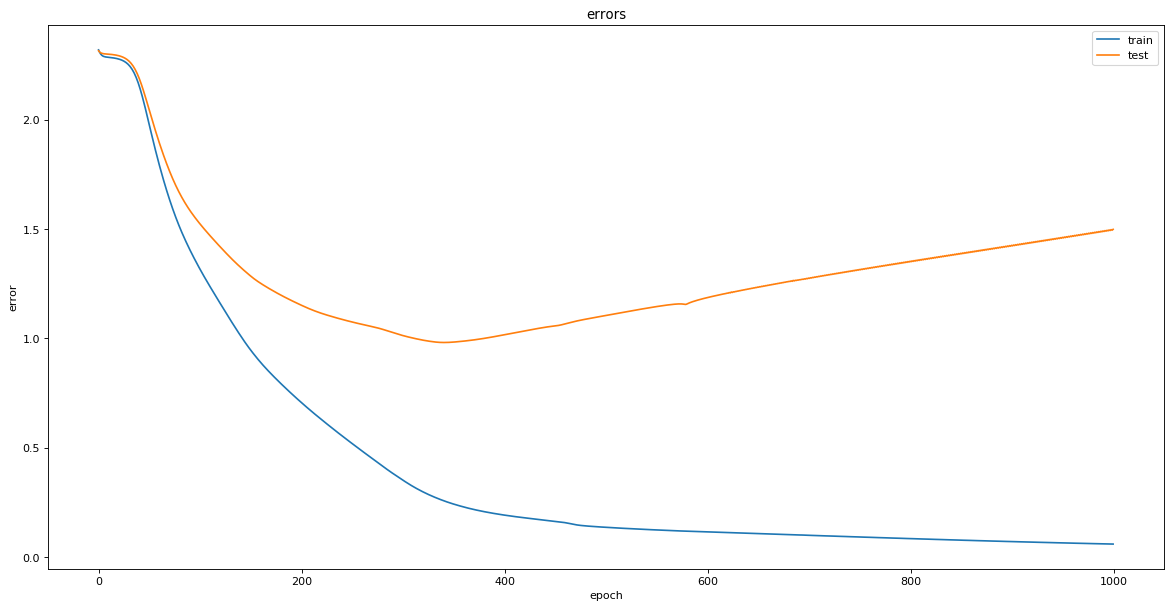

In [9]:
plot_train_test([train_log, test_log], 'loss')

In [ ]:
# torch.from_numpy(a)
# pred = torch.from_numpy(np.array([0.11, 0.99, 0.11])).transpose()
# print(pred)
# pred2 = pred.data.max(1, keepdim=True)[1]
# target = torch.from_numpy(np.array([0, 1, 0]))
# pred.eq(target.data.view_as(pred)).cpu().sum().item()